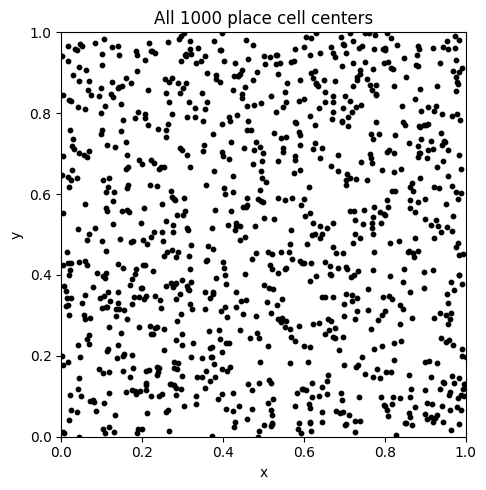

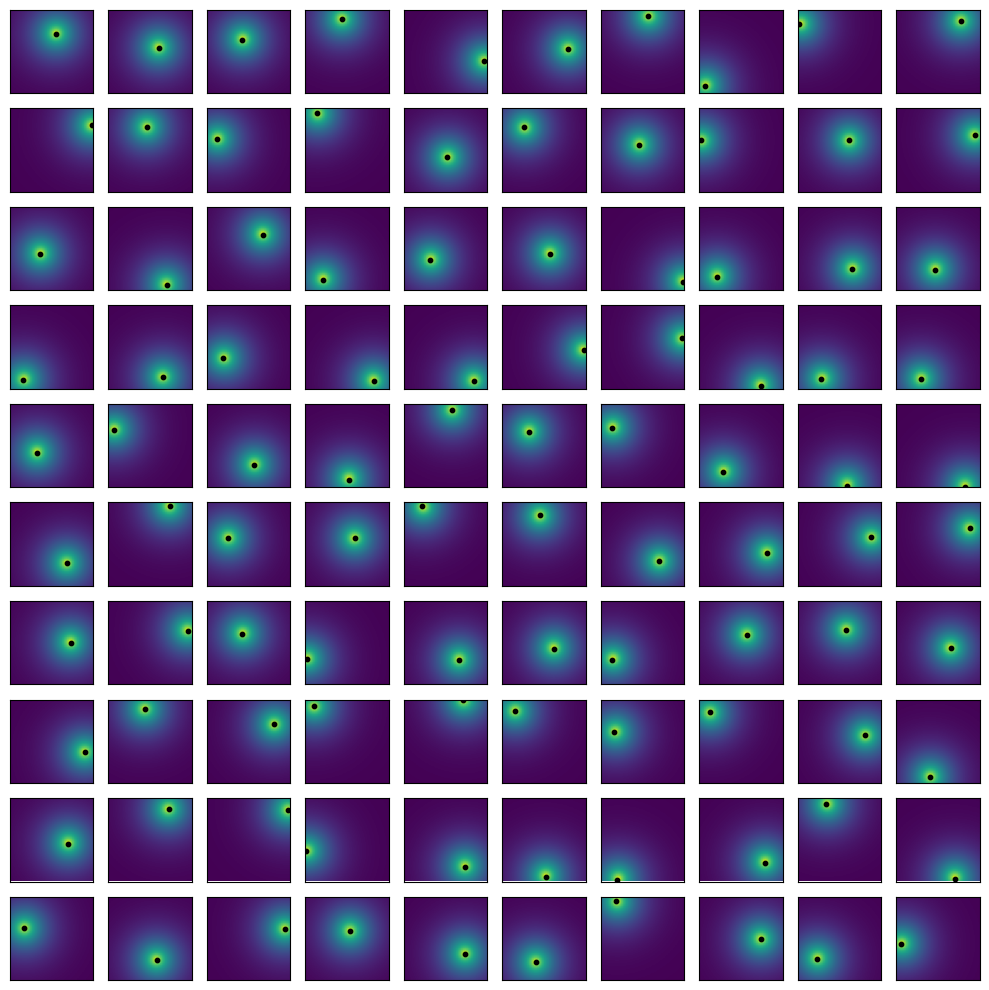

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
n_cells = 1000          # total number of place cells
env_size = 1.0          # environment is [0, 1] x [0, 1]
grid_res = 50           # resolution of the grid to show place fields
length_scale = 0.2      # decay length for exponential kernel (same for all cells)
n_examples = 100        # how many place cells to show in subplots
np.random.seed(0)       # for reproducibility

# --- sample place cell centers uniformly in 2D environment ---
centers = np.random.rand(n_cells, 2) * env_size  # shape: (n_cells, 2)

# --- figure 1: show all centers in black ---
fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.scatter(centers[:, 0], centers[:, 1], s=10, c='black')
ax1.set_xlim(0, env_size)
ax1.set_ylim(0, env_size)
ax1.set_aspect('equal', 'box')
ax1.set_title("All 1000 place cell centers")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
plt.tight_layout()

# --- prepare grid for computing place fields ---
x = np.linspace(0, env_size, grid_res)
y = np.linspace(0, env_size, grid_res)
X, Y = np.meshgrid(x, y)   # shape: (grid_res, grid_res)

def place_field(center, X, Y, length_scale):
    """Exponential decaying place field centered at `center`."""
    cx, cy = center
    dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
    return np.exp(-dist / length_scale)

# --- figure 2: show 100 example place fields in a 10x10 grid ---
fig2, axes = plt.subplots(10, 10, figsize=(10, 10))
axes = axes.ravel()

# use same color scaling for all fields
vmin, vmax = 0.0, 1.0

for i in range(n_examples):
    ax = axes[i]
    c = centers[i]
    field = place_field(c, X, Y, length_scale)
    im = ax.imshow(
        field, origin='lower', extent=[0, env_size, 0, env_size],
        vmin=vmin, vmax=vmax
    )
    # mark the center
    ax.scatter(c[0], c[1], s=10, c='black')
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.set_title(f"{i}", fontsize=6)

# remove empty axes if n_examples < 100 (here it's exactly 100)
for j in range(n_examples, len(axes)):
    fig2.delaxes(axes[j])

# fig2.suptitle("100 example place fields (exponential decay)", y=0.92)
plt.tight_layout()

plt.show()


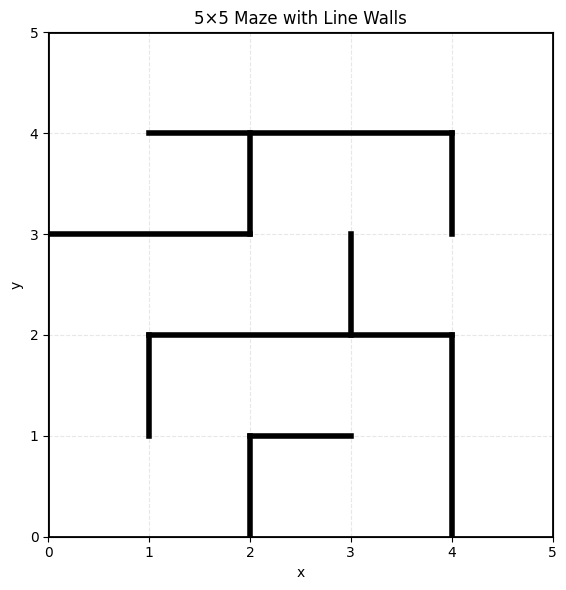

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
env_size = 5.0  # environment is now [0, 5] x [0, 5]

# --- define walls as line segments [x0, y0, x1, y1] ---
walls = np.array([
    [1, 4, 4, 4],
    [4, 4, 4, 3],
    [2, 4, 2, 3],
    [0, 3, 2, 3],
    [1, 1, 1, 2],
    [1, 2, 4, 2],
    [4, 2, 4, 0],
    [3, 2, 3, 3],
    [2, 0, 2, 1],
    [2, 1, 3, 1],
])

# --- visualize maze with walls ---
fig, ax = plt.subplots(figsize=(6, 6))

# draw outer boundary of environment
ax.plot([0, env_size, env_size, 0, 0],
        [0, 0, env_size, env_size, 0],
        'k-', linewidth=2)

# draw all wall segments
for (x0, y0, x1, y1) in walls:
    ax.plot([x0, x1], [y0, y1], 'k-', linewidth=4)

ax.set_xlim(0, env_size)
ax.set_ylim(0, env_size)
ax.set_aspect('equal', 'box')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("5×5 Maze with Line Walls")

# optional: add grid to see coordinates more clearly
ax.set_xticks(np.arange(0, env_size + 1))
ax.set_yticks(np.arange(0, env_size + 1))
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


Using device: cuda


  0%|          | 0/399 [00:00<?, ?it/s]

Trajectories shape: torch.Size([10000, 400, 2])


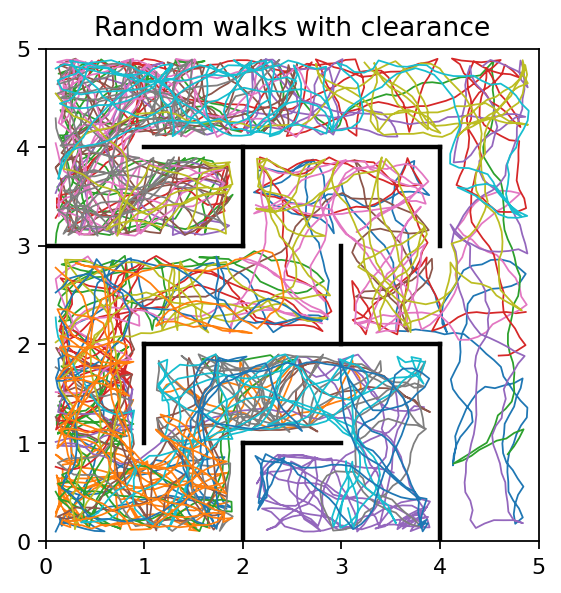

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# =========================
# 0. Basic maze setup
# =========================
env_size = 5.0

walls_np = np.array([
    [1, 4, 4, 4],
    [4, 4, 4, 3],
    [2, 4, 2, 3],
    [0, 3, 2, 3],
    [1, 1, 1, 2],
    [1, 2, 4, 2],
    [4, 2, 4, 0],
    [3, 2, 3, 3],
    [2, 0, 2, 1],
    [2, 1, 3, 1],
], dtype=np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

walls = torch.tensor(walls_np, device=device)  # (n_walls, 4)

# split vertical / horizontal walls for simpler vectorized collision checks
is_vertical = torch.isclose(walls[:, 0], walls[:, 2])
is_horizontal = torch.isclose(walls[:, 1], walls[:, 3])
vert_walls = walls[is_vertical]      # (n_v, 4)
horiz_walls = walls[is_horizontal]   # (n_h, 4)

# =========================
# 1. Helper: sample directions in constrained half-planes
# =========================
def sample_direction_halfplane(sign_x=None, sign_y=None, size=None, device=None):
    """
    Sample angles uniformly from the half-plane/quadrant that moves away from a wall/boundary.
    sign_x: +1 (vx>0), -1 (vx<0), or None
    sign_y: +1 (vy>0), -1 (vy<0), or None
    size: number of angles
    """
    size = int(size)
    if size == 0:
        return torch.empty(0, device=device)

    # if only x constraint
    if sign_x is not None and sign_y is None:
        if sign_x > 0:
            # vx > 0 -> theta in (-pi/2, pi/2)
            theta = (torch.rand(size, device=device) - 0.5) * torch.pi
        else:
            # vx < 0 -> theta in (pi/2, 3pi/2)
            theta = (torch.rand(size, device=device) * torch.pi) + torch.pi / 2
    # if only y constraint
    elif sign_y is not None and sign_x is None:
        if sign_y > 0:
            # vy > 0 -> theta in (0, pi)
            theta = torch.rand(size, device=device) * torch.pi
        else:
            # vy < 0 -> theta in (pi, 2pi)
            theta = torch.rand(size, device=device) * torch.pi + torch.pi
    # if both constraints -> pick quadrant
    elif sign_x is not None and sign_y is not None:
        if sign_x > 0 and sign_y > 0:
            # Q1: (0, pi/2)
            theta = torch.rand(size, device=device) * (torch.pi / 2)
        elif sign_x < 0 and sign_y > 0:
            # Q2: (pi/2, pi)
            theta = torch.rand(size, device=device) * (torch.pi / 2) + torch.pi / 2
        elif sign_x < 0 and sign_y < 0:
            # Q3: (pi, 3pi/2)
            theta = torch.rand(size, device=device) * (torch.pi / 2) + torch.pi
        else:
            # Q4: (3pi/2, 2pi)
            theta = torch.rand(size, device=device) * (torch.pi / 2) + 3 * torch.pi / 2
    else:
        # no constraint -> full circle
        theta = torch.rand(size, device=device) * 2 * torch.pi

    return theta

# =========================
# 2. Parallel trajectory simulator (with clearance to walls + boundaries)
# =========================
def simulate_all_trajectories(
    start_points,           # (n_starts, 2)
    n_traj_per_start=10,
    n_steps=1000,
    step_size=0.1,
    angle_noise_std=0.3,
    clearance=0.08,         # <-- NEW: keep at least this distance to all walls and boundaries
    device=device,
):
    """
    start_points: (n_starts, 2) points in [0, env_size]^2
    Returns:
        trajs: (n_total_traj, n_steps, 2) on device
    """

    start_points = start_points.to(device)

    n_starts = start_points.shape[0]
    n_total = n_starts * n_traj_per_start

    # Expand starts: each start gets n_traj_per_start copies
    starts_expanded = start_points.repeat_interleave(n_traj_per_start, dim=0)  # (n_total, 2)

    # OPTIONAL: clamp starts away from *boundaries* so we don't immediately violate clearance
    starts_expanded = starts_expanded.clamp(clearance, env_size - clearance)

    # initialize positions and directions
    pos = starts_expanded.clone()
    theta = torch.rand(n_total, device=device) * 2 * torch.pi

    trajs = torch.empty(n_total, n_steps, 2, device=device)
    trajs[:, 0, :] = pos

    eps = 1e-9
    max_tries = 10  # a bit higher now that we enforce clearance tubes

    for t in tqdm(range(1, n_steps)):
        # propose move
        theta = theta + torch.randn(n_total, device=device) * angle_noise_std
        direction = torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
        new_pos = pos + step_size * direction

        for _ in range(max_tries):

            # =========================
            # 1) boundary "too-close" (clearance) checks
            # =========================
            sign_x = torch.zeros(n_total, device=device)  # -1, 0, +1
            sign_y = torch.zeros(n_total, device=device)

            left_mask   = new_pos[:, 0] < clearance
            right_mask  = new_pos[:, 0] > (env_size - clearance)
            bottom_mask = new_pos[:, 1] < clearance
            top_mask    = new_pos[:, 1] > (env_size - clearance)

            sign_x[left_mask]   = +1
            sign_x[right_mask]  = -1
            sign_y[bottom_mask] = +1
            sign_y[top_mask]    = -1

            boundary_mask = left_mask | right_mask | bottom_mask | top_mask

            if boundary_mask.any():
                idx = torch.nonzero(boundary_mask, as_tuple=False).squeeze(-1)
                sx = sign_x[idx]
                sy = sign_y[idx]
                for i_local, i in enumerate(idx):
                    sx_i = int(sx[i_local].item())
                    sy_i = int(sy[i_local].item())
                    sx_arg = None if sx_i == 0 else sx_i
                    sy_arg = None if sy_i == 0 else sy_i
                    theta_i = sample_direction_halfplane(sign_x=sx_arg, sign_y=sy_arg, size=1, device=device)
                    theta[i] = theta_i[0]

                direction = torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
                new_pos = pos + step_size * direction

            # =========================
            # 2) wall crossing + "too-close" tube checks
            # =========================
            pos_x = pos[:, 0]; pos_y = pos[:, 1]
            new_x = new_pos[:, 0]; new_y = new_pos[:, 1]

            any_collided_v = torch.zeros(n_total, dtype=torch.bool, device=device)
            any_collided_h = torch.zeros(n_total, dtype=torch.bool, device=device)

            # We'll keep collided_v/h tensors defined if there are walls (needed later for resolving)
            collided_v = None
            collided_h = None

            # --- vertical walls ---
            if vert_walls.shape[0] > 0:
                xw = vert_walls[:, 0]
                y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
                y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])

                pos_x_exp = pos_x.unsqueeze(1)
                new_x_exp = new_x.unsqueeze(1)
                pos_y_exp = pos_y.unsqueeze(1)
                new_y_exp = new_y.unsqueeze(1)

                # crossing (or touching)
                crossed_x = (pos_x_exp - xw) * (new_x_exp - xw) <= eps
                within_y  = (torch.maximum(pos_y_exp, new_y_exp) >= y0 - eps) & \
                            (torch.minimum(pos_y_exp, new_y_exp) <= y1 + eps)

                # NEW: too-close tube around wall (based on NEW POSITION)
                near_x = (torch.abs(new_x_exp - xw) < clearance)
                near_y = (new_y_exp >= (y0 - clearance)) & (new_y_exp <= (y1 + clearance))
                too_close_v = near_x & near_y

                collided_v = (crossed_x & within_y) | too_close_v
                any_collided_v = collided_v.any(dim=1)

            # --- horizontal walls ---
            if horiz_walls.shape[0] > 0:
                yw = horiz_walls[:, 1]
                x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
                x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])

                pos_y_exp = pos_y.unsqueeze(1)
                new_y_exp = new_y.unsqueeze(1)
                pos_x_exp = pos_x.unsqueeze(1)
                new_x_exp = new_x.unsqueeze(1)

                crossed_y = (pos_y_exp - yw) * (new_y_exp - yw) <= eps
                within_x  = (torch.maximum(pos_x_exp, new_x_exp) >= x0 - eps) & \
                            (torch.minimum(pos_x_exp, new_x_exp) <= x1 + eps)

                # NEW: too-close tube around wall (based on NEW POSITION)
                near_y = (torch.abs(new_y_exp - yw) < clearance)
                near_x = (new_x_exp >= (x0 - clearance)) & (new_x_exp <= (x1 + clearance))
                too_close_h = near_y & near_x

                collided_h = (crossed_y & within_x) | too_close_h
                any_collided_h = collided_h.any(dim=1)

            any_wall = any_collided_v | any_collided_h
            if not any_wall.any() and (not boundary_mask.any()):
                break  # safe step wrt both walls and boundaries

            # ---- resolve vertical wall issues ----
            if any_collided_v.any():
                idx_v = torch.nonzero(any_collided_v, as_tuple=False).squeeze(-1)
                # pick first wall that triggered (argmax over bool -> works after float cast)
                wall_idx_v = collided_v[idx_v].float().argmax(dim=1)
                xw_for = xw[wall_idx_v]
                pos_x_for = pos_x[idx_v]

                # if we are left of wall -> move left (vx<0) to increase distance;
                # if we are right of wall -> move right (vx>0)
                sx = torch.where(
                    pos_x_for < xw_for,
                    -torch.ones_like(pos_x_for),
                    torch.ones_like(pos_x_for),
                )
                for j_local, j in enumerate(idx_v):
                    sx_j = int(sx[j_local].item())
                    theta_j = sample_direction_halfplane(sign_x=sx_j, sign_y=None, size=1, device=device)
                    theta[j] = theta_j[0]

            # ---- resolve horizontal wall issues ----
            if any_collided_h.any():
                idx_h = torch.nonzero(any_collided_h, as_tuple=False).squeeze(-1)
                wall_idx_h = collided_h[idx_h].float().argmax(dim=1)
                yw_for = yw[wall_idx_h]
                pos_y_for = pos_y[idx_h]

                # if we are below wall -> move down (vy<0); if above -> move up (vy>0)
                sy = torch.where(
                    pos_y_for < yw_for,
                    -torch.ones_like(pos_y_for),
                    torch.ones_like(pos_y_for),
                )
                for j_local, j in enumerate(idx_h):
                    sy_j = int(sy[j_local].item())
                    theta_j = sample_direction_halfplane(sign_x=None, sign_y=sy_j, size=1, device=device)
                    theta[j] = theta_j[0]

            # recompute move after resampling
            direction = torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
            new_pos = pos + step_size * direction

        # final safety clamp to boundaries (keeps clearance even if we ran out of tries)
        new_pos[:, 0] = new_pos[:, 0].clamp(clearance, env_size - clearance)
        new_pos[:, 1] = new_pos[:, 1].clamp(clearance, env_size - clearance)

        pos = new_pos
        trajs[:, t, :] = pos

    return trajs


# =========================
# 3. Build a grid of starts and run
# =========================
grid_res = 100
xs = torch.linspace(0.0, env_size, grid_res, device=device)
ys = torch.linspace(0.0, env_size, grid_res, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing='xy')
grid_points = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)  # (grid_res^2, 2)

torch.manual_seed(0)
trajs = simulate_all_trajectories(
    grid_points,
    n_traj_per_start=1,
    n_steps=400,
    step_size=0.1,
    angle_noise_std=0.3,
    clearance=0.1,   # <-- adjust as you like
    device=device,
)

print("Trajectories shape:", trajs.shape)  # (grid_res^2, n_steps, 2)


# =========================
# 4. (Optional) Quick sanity plot of a few trajectories
# =========================
tr = trajs.detach().cpu().numpy()
plt.figure(figsize=(4, 4), dpi=160)
for k in range(0, tr.shape[0], max(1, tr.shape[0] // 20)):  # plot ~20 trajs
    plt.plot(tr[k, :, 0], tr[k, :, 1], linewidth=0.8)

# plot walls
for (x1, y1, x2, y2) in walls_np:
    plt.plot([x1, x2], [y1, y2], linewidth=2,c='black')

plt.xlim(0, env_size)
plt.ylim(0, env_size)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Random walks with clearance")
plt.show()


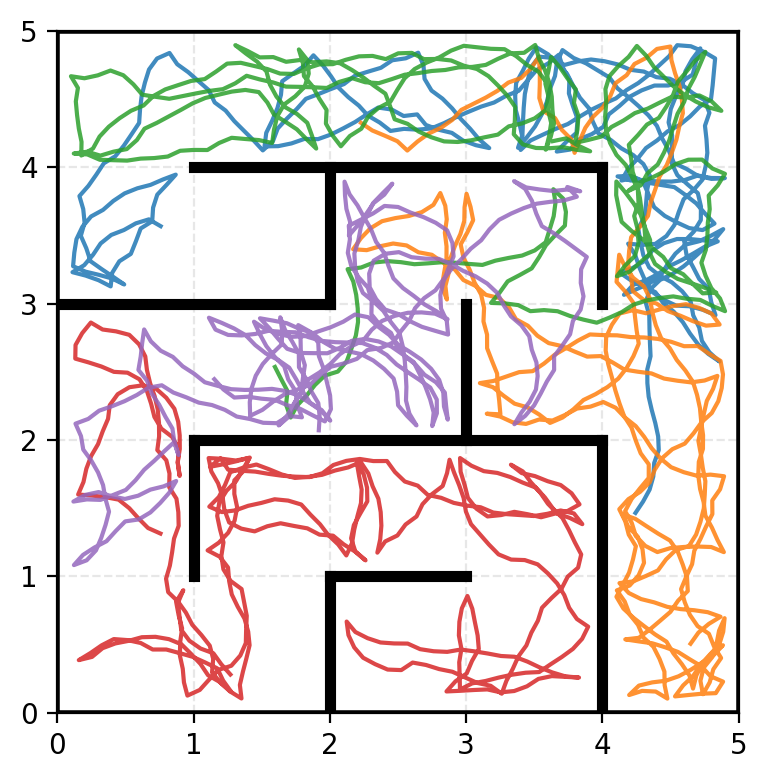

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ---- select 5 random trajectories ----
trajs_np = trajs.detach().cpu().numpy()
n_total = trajs_np.shape[0]

rng = np.random.default_rng(2)
idx5 = rng.choice(n_total, size=5, replace=False)

# ---- plot ----
env_size = 5.0
walls_plot = walls_np

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

# outer boundary
ax.plot([0, env_size, env_size, 0, 0],
        [0, 0, env_size, env_size, 0],
        'k-', linewidth=2)

# walls
for (x0, y0, x1, y1) in walls_plot:
    ax.plot([x0, x1], [y0, y1], 'k-', linewidth=4)

# overlay 5 trajectories (default matplotlib colors)
for i in idx5:
    tr = trajs_np[i]
    ax.plot(tr[:, 0], tr[:, 1], linewidth=1.5, alpha=0.85)
#     ax.plot(tr[0, 0], tr[0, 1], 'o', markersize=15,c='black')  # start point

ax.set_xlim(0, env_size)
ax.set_ylim(0, env_size)
ax.set_aspect('equal', 'box')
ax.set_xticks(np.arange(0, env_size + 1))
ax.set_yticks(np.arange(0, env_size + 1))
ax.grid(True, linestyle='--', alpha=0.3)
# ax.set_title("5 example trajectories (random starts)")

plt.tight_layout()
plt.show()


Using device: cuda
Chosen start: [2.5 2.5]  (closest grid point to [2.5,2.5])


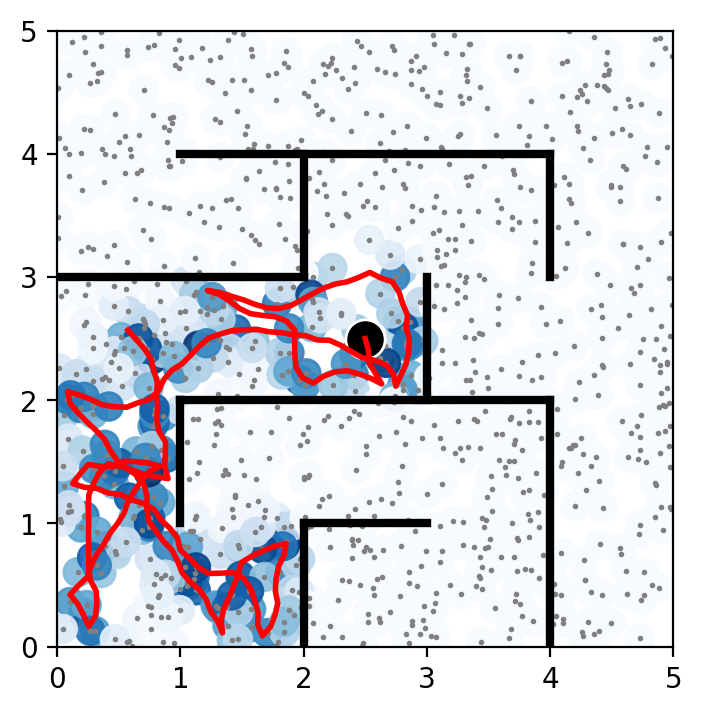

In [14]:
# =========================
# FROM SCRATCH (UPDATED):
# one trajectory near (2.5,2.5) + place centers colored by max response
# with CLEARANCE to all walls + boundaries
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------------------------
# 0) Device + seed
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 3
torch.manual_seed(seed)
np.random.seed(seed)

# -------------------------
# 1) Maze definition
# -------------------------
env_size = 5.0

walls_np = np.array([
    [1, 4, 4, 4],
    [4, 4, 4, 3],
    [2, 4, 2, 3],
    [0, 3, 2, 3],
    [1, 1, 1, 2],
    [1, 2, 4, 2],
    [4, 2, 4, 0],
    [3, 2, 3, 3],
    [2, 0, 2, 1],
    [2, 1, 3, 1],
], dtype=np.float32)

walls = torch.tensor(walls_np, device=device)  # (n_walls, 4)

is_vertical = torch.isclose(walls[:, 0], walls[:, 2])
is_horizontal = torch.isclose(walls[:, 1], walls[:, 3])
vert_walls = walls[is_vertical]      # (n_v, 4)
horiz_walls = walls[is_horizontal]   # (n_h, 4)

# -------------------------
# 2) Helper: sample directions in constrained half-planes
# -------------------------
def sample_direction_halfplane(sign_x=None, sign_y=None, size=1, device=None):
    """
    Uniform angles from a half-plane/quadrant satisfying sign constraints.
    sign_x: +1 => vx>0, -1 => vx<0, None => no x constraint
    sign_y: +1 => vy>0, -1 => vy<0, None => no y constraint
    """
    size = int(size)
    if size == 0:
        return torch.empty(0, device=device)

    if sign_x is not None and sign_y is None:
        if sign_x > 0:
            # cos(theta)>0 -> theta in (-pi/2, pi/2)
            return (torch.rand(size, device=device) - 0.5) * torch.pi
        else:
            # cos(theta)<0 -> theta in (pi/2, 3pi/2)
            return torch.rand(size, device=device) * torch.pi + torch.pi/2

    if sign_y is not None and sign_x is None:
        if sign_y > 0:
            # sin(theta)>0 -> theta in (0, pi)
            return torch.rand(size, device=device) * torch.pi
        else:
            # sin(theta)<0 -> theta in (pi, 2pi)
            return torch.rand(size, device=device) * torch.pi + torch.pi

    if sign_x is not None and sign_y is not None:
        if sign_x > 0 and sign_y > 0:
            return torch.rand(size, device=device) * (torch.pi/2) + 0
        if sign_x < 0 and sign_y > 0:
            return torch.rand(size, device=device) * (torch.pi/2) + torch.pi/2
        if sign_x < 0 and sign_y < 0:
            return torch.rand(size, device=device) * (torch.pi/2) + torch.pi
        # sign_x > 0 and sign_y < 0
        return torch.rand(size, device=device) * (torch.pi/2) + 3*torch.pi/2

    # no constraint
    return torch.rand(size, device=device) * 2 * torch.pi

# -------------------------
# 3) Helper: check if a point is within clearance of ANY wall
# -------------------------
@torch.no_grad()
def point_too_close_to_any_wall(pt_xy, clearance):
    """
    pt_xy: (2,) on device
    returns bool tensor scalar
    """
    x, y = pt_xy[0], pt_xy[1]
    too_close = torch.tensor(False, device=device)

    # vertical walls: distance in x + y within segment range (expanded by clearance)
    if vert_walls.shape[0] > 0:
        xw = vert_walls[:, 0]
        y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
        y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])

        near_x = torch.abs(x - xw) < clearance
        near_y = (y >= (y0 - clearance)) & (y <= (y1 + clearance))
        too_close = too_close | (near_x & near_y).any()

    # horizontal walls: distance in y + x within segment range (expanded by clearance)
    if horiz_walls.shape[0] > 0:
        yw = horiz_walls[:, 1]
        x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
        x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])

        near_y = torch.abs(y - yw) < clearance
        near_x = (x >= (x0 - clearance)) & (x <= (x1 + clearance))
        too_close = too_close | (near_y & near_x).any()

    return too_close
@torch.no_grad()
def visibility_mask_traj_to_centers(traj, centers, vert_walls, horiz_walls, eps=1e-9):
    """
    traj:    (T,2) on device
    centers: (P,2) on device
    returns: visible (T,P) bool, True = not blocked by any wall
    """

    T = traj.shape[0]
    P = centers.shape[0]

    ax = traj[:, 0].unsqueeze(1)      # (T,1)
    ay = traj[:, 1].unsqueeze(1)
    bx = centers[:, 0].unsqueeze(0)   # (1,P)
    by = centers[:, 1].unsqueeze(0)

    blocked = torch.zeros((T, P), dtype=torch.bool, device=traj.device)

    # ---- vertical walls: x = xw, y in [y0,y1]
    if vert_walls.numel() > 0:
        xw = vert_walls[:, 0]  # (Wv,)
        y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
        y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])

        # broadcast to (T,P,Wv)
        axw = ax.unsqueeze(2)
        bxw = bx.unsqueeze(2)
        ayw = ay.unsqueeze(2)
        byw = by.unsqueeze(2)

        xw_ = xw.view(1, 1, -1)
        y0_ = y0.view(1, 1, -1)
        y1_ = y1.view(1, 1, -1)

        crossed_x = (axw - xw_) * (bxw - xw_) <= eps
        within_y  = (torch.maximum(ayw, byw) >= (y0_ - eps)) & (torch.minimum(ayw, byw) <= (y1_ + eps))

        hit_v = crossed_x & within_y           # (T,P,Wv)
        blocked |= hit_v.any(dim=2)            # (T,P)

    # ---- horizontal walls: y = yw, x in [x0,x1]
    if horiz_walls.numel() > 0:
        yw = horiz_walls[:, 1]  # (Wh,)
        x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
        x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])

        axw = ax.unsqueeze(2)
        bxw = bx.unsqueeze(2)
        ayw = ay.unsqueeze(2)
        byw = by.unsqueeze(2)

        yw_ = yw.view(1, 1, -1)
        x0_ = x0.view(1, 1, -1)
        x1_ = x1.view(1, 1, -1)

        crossed_y = (ayw - yw_) * (byw - yw_) <= eps
        within_x  = (torch.maximum(axw, bxw) >= (x0_ - eps)) & (torch.minimum(axw, bxw) <= (x1_ + eps))

        hit_h = crossed_y & within_x
        blocked |= hit_h.any(dim=2)

    return ~blocked

# -------------------------
# 4) One-trajectory simulator (CLEARANCE to walls + boundaries)
# -------------------------
@torch.no_grad()
def simulate_one_trajectory(
    start_xy,              # (2,) tensor on device
    n_steps=200,
    step_size=0.1,
    angle_noise_std=0.3,
    clearance=0.08,
    max_tries=12,
):
    # clamp start away from boundaries
    pos = start_xy.clone()
    pos[0] = pos[0].clamp(clearance, env_size - clearance)
    pos[1] = pos[1].clamp(clearance, env_size - clearance)

    # if start is too close to a wall, nudge by random resampling until valid (best effort)
    for _ in range(50):
        if not point_too_close_to_any_wall(pos, clearance):
            break
        th = torch.rand((), device=device) * 2 * torch.pi
        pos = pos + 0.5 * clearance * torch.stack([torch.cos(th), torch.sin(th)])
        pos[0] = pos[0].clamp(clearance, env_size - clearance)
        pos[1] = pos[1].clamp(clearance, env_size - clearance)

    theta = torch.rand((), device=device) * 2 * torch.pi

    traj = torch.empty(n_steps, 2, device=device)
    traj[0] = pos

    eps = 1e-9

    for t in range(1, n_steps):
        theta = theta + torch.randn((), device=device) * angle_noise_std
        direction = torch.stack([torch.cos(theta), torch.sin(theta)], dim=0)
        new_pos = pos + step_size * direction

        for _ in range(max_tries):
            # ---- boundary clearance checks
            sx = None
            sy = None
            if new_pos[0] < clearance:
                sx = +1
            elif new_pos[0] > (env_size - clearance):
                sx = -1
            if new_pos[1] < clearance:
                sy = +1
            elif new_pos[1] > (env_size - clearance):
                sy = -1

            if (sx is not None) or (sy is not None):
                theta = sample_direction_halfplane(sign_x=sx, sign_y=sy, size=1, device=device)[0]
                direction = torch.stack([torch.cos(theta), torch.sin(theta)], dim=0)
                new_pos = pos + step_size * direction
                continue

            # ---- wall crossing + wall clearance-tube checks
            px, py = pos[0], pos[1]
            nx, ny = new_pos[0], new_pos[1]

            hit_v = torch.tensor(False, device=device)
            hit_h = torch.tensor(False, device=device)

            # vertical walls
            if vert_walls.shape[0] > 0:
                xw = vert_walls[:, 0]
                y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
                y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])

                crossed_x = (px - xw) * (nx - xw) <= eps
                within_y  = (torch.maximum(py, ny) >= (y0 - eps)) & (torch.minimum(py, ny) <= (y1 + eps))

                near_x = torch.abs(nx - xw) < clearance
                near_y = (ny >= (y0 - clearance)) & (ny <= (y1 + clearance))

                hit_v = ((crossed_x & within_y) | (near_x & near_y)).any()

            # horizontal walls
            if horiz_walls.shape[0] > 0:
                yw = horiz_walls[:, 1]
                x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
                x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])

                crossed_y = (py - yw) * (ny - yw) <= eps
                within_x  = (torch.maximum(px, nx) >= (x0 - eps)) & (torch.minimum(px, nx) <= (x1 + eps))

                near_y = torch.abs(ny - yw) < clearance
                near_x = (nx >= (x0 - clearance)) & (nx <= (x1 + clearance))

                hit_h = ((crossed_y & within_x) | (near_y & near_x)).any()

            if (not hit_v) and (not hit_h) and (not point_too_close_to_any_wall(new_pos, clearance)):
                break  # safe

            # resolve: resample away from the first offending wall type (simple heuristic)
            if hit_v and vert_walls.shape[0] > 0:
                xw = vert_walls[:, 0]
                # pick nearest vertical wall in x to current pos (cheap heuristic)
                wi = torch.argmin(torch.abs(px - xw)).item()
                wall_x = xw[wi]
                sx = -1 if (px < wall_x) else +1   # left -> go left, right -> go right
                theta = sample_direction_halfplane(sign_x=sx, sign_y=None, size=1, device=device)[0]
            elif hit_h and horiz_walls.shape[0] > 0:
                yw = horiz_walls[:, 1]
                wi = torch.argmin(torch.abs(py - yw)).item()
                wall_y = yw[wi]
                sy = -1 if (py < wall_y) else +1   # below -> go down, above -> go up
                theta = sample_direction_halfplane(sign_x=None, sign_y=sy, size=1, device=device)[0]
            else:
                # fallback: random direction
                theta = torch.rand((), device=device) * 2 * torch.pi

            direction = torch.stack([torch.cos(theta), torch.sin(theta)], dim=0)
            new_pos = pos + step_size * direction

        # final boundary clamp (keeps clearance even if we ran out of tries)
        new_pos[0] = new_pos[0].clamp(clearance, env_size - clearance)
        new_pos[1] = new_pos[1].clamp(clearance, env_size - clearance)

        pos = new_pos
        traj[t] = pos

    return traj  # (T,2)

# -------------------------
# 5) Choose a start "near (2.5,2.5)" from a small grid, then simulate ONE traj
# -------------------------
target = torch.tensor([2.5, 2.5], device=device)

start_grid_res = 21
xs = torch.linspace(0.0, env_size, start_grid_res, device=device)
ys = torch.linspace(0.0, env_size, start_grid_res, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
start_points = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)  # (M,2)

idx_start = torch.argmin(((start_points - target) ** 2).sum(dim=1)).item()
start_xy = start_points[idx_start]
print("Chosen start:", start_xy.detach().cpu().numpy(), " (closest grid point to [2.5,2.5])")

traj = simulate_one_trajectory(
    start_xy=start_xy,
    n_steps=200,
    step_size=0.1,
    angle_noise_std=0.3,
    clearance=0.08,   # <-- same clearance idea as the batch simulator
)

# -------------------------
# 6) Place cells + max response on this trajectory (NO RESPONSE THROUGH WALLS)
# -------------------------
P = 1000
length_scale = 0.1  # tune

place_centers = torch.rand(P, 2, device=device) * env_size  # (P,2)

# visibility: (T,P) True if segment traj[t] -> center does NOT cross any wall
visible = visibility_mask_traj_to_centers(traj, place_centers, vert_walls, horiz_walls)

# distance-based activation
diff = traj[:, None, :] - place_centers[None, :, :]         # (T,P,2)
dist = torch.sqrt((diff ** 2).sum(dim=2) + 1e-12)           # (T,P)
act = torch.exp(-dist / length_scale)                       # (T,P)

# enforce wall rule
act = act * visible.float()

pc_max = act.max(dim=0).values                              # (P,)


# -------------------------
# 7) Plot: walls + trajectory + centers colored by pc_max
# -------------------------
traj_cpu = traj.detach().cpu().numpy()
centers_cpu = place_centers.detach().cpu().numpy()
pc_max_cpu = pc_max.detach().cpu().numpy()
walls_cpu = walls.detach().cpu().numpy()

plt.figure(figsize=(4, 4),dpi=200)

# walls
for (x0, y0, x1, y1) in walls_cpu:
    plt.plot([x0, x1], [y0, y1], linewidth=3, c="black")

# trajectory
plt.plot(traj_cpu[:, 0], traj_cpu[:, 1], linewidth=2, c="red", label="trajectory")

# centers colored by max response (and also a tiny gray layer like you had)
sc = plt.scatter(
    centers_cpu[:, 0],
    centers_cpu[:, 1],
    c=pc_max_cpu,
    s=100,
    alpha=0.9,
    cmap="Blues",
)

plt.scatter(
    centers_cpu[:, 0],
    centers_cpu[:, 1],
    c="gray",
    s=1,
    alpha=1,
)

plt.scatter(traj_cpu[0, 0], traj_cpu[0, 1], s=200, marker="o",
            c="black", edgecolor="white", label="start")
# plt.scatter(traj_cpu[-1, 0], traj_cpu[-1, 1], s=80, marker="x", label="end")

plt.xlim(0, env_size)
plt.ylim(0, env_size)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 0. Assumed available from your previous CUDA code:
# ----------------------------------------------------
# env_size = 5.0
# walls     : (n_walls, 4) on device
# trajs     : (9000, 1000, 2) on device
# device    : torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_total_traj, T, _ = trajs.shape
print("Trajs shape:", trajs.shape, "on", device)

# ============================================
# 1. Define place cells on GPU
# ============================================
torch.manual_seed(0)

n_place_cells = 10000
length_scale = 0.15  # tune as you like for 5x5 env

place_centers = torch.rand(n_place_cells, 2, device=device) * env_size  # (1000, 2)


# ============================================
# 2. Batched place activation + memory vectors
# ============================================
def compute_memory_vectors_batched(trajs, place_centers, length_scale, batch_size=32):
    """
    trajs:         (N, T, 2) on device
    place_centers: (P, 2) on device
    returns:
        memory_vectors: (N, P) on device
        where each row is max_t exp(-dist(pos_t, center_p) / length_scale)
    """
    N, T, dim = trajs.shape
    P = place_centers.shape[0]
    assert dim == 2

    memory_vectors = torch.empty(N, P, device=trajs.device)

    for start in range(0, N, batch_size):
        end = min(start + batch_size, N)
        B = end - start
        batch = trajs[start:end]          # (B, T, 2)

        # Flatten time dimension for distance computation
        # positions: (B*T, 2)
        positions = batch.reshape(B * T, 2)

        # Compute squared distances in a vectorized way:
        # dist^2 = |x|^2 + |c|^2 - 2 x·c
        # positions: (BT, 2)
        # centers:   (P, 2)
        pos_sq = (positions ** 2).sum(dim=1, keepdim=True)         # (BT, 1)
        cen_sq = (place_centers ** 2).sum(dim=1).unsqueeze(0)      # (1, P)
        cross = positions @ place_centers.t()                      # (BT, P)

        dist_sq = pos_sq + cen_sq - 2 * cross                      # (BT, P)
        dist_sq = torch.clamp(dist_sq, min=0.0)
        dist = torch.sqrt(dist_sq + 1e-12)                         # (BT, P)

        activations = torch.exp(-dist / length_scale)              # (BT, P)

        # reshape back to (B, T, P) and max over time
        activations = activations.reshape(B, T, P)
        mem_batch = activations.max(dim=1).values                  # (B, P)

        memory_vectors[start:end] = mem_batch

        print(f"Computed memory vectors for trajectories {start}–{end-1}")

    return memory_vectors


memory_vectors = compute_memory_vectors_batched(
    trajs,
    place_centers,
    length_scale,
    batch_size=32,
)

print("memory_vectors shape:", memory_vectors.shape)  # (9000, 1000)


# ============================================
# 3. Build W_pc_to_mem (place -> memory)
# ============================================
# memory_vectors: (N_mem=9000, P=1000)
# W_pc_to_mem:    (P=1000, N_mem=9000)
W_pc_to_mem = memory_vectors.t().contiguous()
print("W_pc_to_mem shape:", W_pc_to_mem.shape)


# ============================================
# 4. Embed 30x30 grid points via place cells + memory
# ============================================
grid_res = 100
xs = torch.linspace(0.0, env_size, grid_res, device=device)
ys = torch.linspace(0.0, env_size, grid_res, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing='xy')
grid_points = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)  # (900, 2)
def place_activation_positions(
    positions,
    place_centers,
    length_scale,
    walls,
    batch_size=256,
):
    """
    positions:     (M, 2)
    place_centers: (P, 2)
    walls:         (n_walls, 4)  [x0, y0, x1, y1], axis-aligned
    returns:       (M, P) activations with fields cut by walls
    """
    device = positions.device
    M = positions.shape[0]
    P = place_centers.shape[0]

    # split vertical / horizontal walls
    is_vertical = torch.isclose(walls[:, 0], walls[:, 2])
    is_horizontal = torch.isclose(walls[:, 1], walls[:, 3])
    vert_walls = walls[is_vertical]
    horiz_walls = walls[is_horizontal]

    activations_out = torch.empty(M, P, device=device)
    eps = 1e-8

    for start in range(0, M, batch_size):
        end = min(start + batch_size, M)
        pos_batch = positions[start:end]        # (B, 2)
        B = pos_batch.shape[0]

        # ----- base Gaussian activations (Euclidean distance) -----
        pos_sq = (pos_batch ** 2).sum(dim=1, keepdim=True)        # (B, 1)
        cen_sq = (place_centers ** 2).sum(dim=1).unsqueeze(0)     # (1, P)
        cross = pos_batch @ place_centers.t()                     # (B, P)

        dist_sq = pos_sq + cen_sq - 2 * cross                     # (B, P)
        dist_sq = torch.clamp(dist_sq, min=0.0)
        dist = torch.sqrt(dist_sq + 1e-12)
        activations_batch = torch.exp(-dist / length_scale)       # (B, P)

        # ----- visibility mask: cut fields across walls -----
        visible = torch.ones(B, P, dtype=torch.bool, device=device)

        X0 = pos_batch[:, 0].unsqueeze(1)   # (B, 1)
        Y0 = pos_batch[:, 1].unsqueeze(1)   # (B, 1)
        X1 = place_centers[:, 0].unsqueeze(0)  # (1, P)
        Y1 = place_centers[:, 1].unsqueeze(0)  # (1, P)

        # --- vertical walls ---
        if vert_walls.shape[0] > 0:
            for w in range(vert_walls.shape[0]):
                xw = vert_walls[w, 0]
                y0w = torch.minimum(vert_walls[w, 1], vert_walls[w, 3])
                y1w = torch.maximum(vert_walls[w, 1], vert_walls[w, 3])

                dx0 = X0 - xw
                dx1 = X1 - xw
                crossed = (dx0 * dx1) < 0                          # (B, P)

                denom = (X1 - X0)
                denom_safe = torch.where(
                    torch.abs(denom) < eps,
                    torch.full_like(denom, eps),
                    denom,
                )
                y_int = Y0 + (xw - X0) * (Y1 - Y0) / denom_safe    # (B, P)
                within_y = (y_int >= y0w) & (y_int <= y1w)

                blocked = crossed & within_y
                visible[blocked] = False

        # --- horizontal walls ---
        if horiz_walls.shape[0] > 0:
            for w in range(horiz_walls.shape[0]):
                yw = horiz_walls[w, 1]
                x0w = torch.minimum(horiz_walls[w, 0], horiz_walls[w, 2])
                x1w = torch.maximum(horiz_walls[w, 0], horiz_walls[w, 2])

                dy0 = Y0 - yw
                dy1 = Y1 - yw
                crossed = (dy0 * dy1) < 0                          # (B, P)

                denom = (Y1 - Y0)
                denom_safe = torch.where(
                    torch.abs(denom) < eps,
                    torch.full_like(denom, eps),
                    denom,
                )
                x_int = X0 + (yw - Y0) * (X1 - X0) / denom_safe    # (B, P)
                within_x = (x_int >= x0w) & (x_int <= x1w)

                blocked = crossed & within_x
                visible[blocked] = False

        # zero activations where line-of-sight is blocked
        activations_batch = activations_batch * visible.float()
        activations_out[start:end] = activations_batch

    return activations_out

# def place_activation_positions(positions, place_centers, length_scale):
#     """
#     positions:     (M, 2)
#     place_centers: (P, 2)
#     returns:       (M, P) activations
#     """
#     M = positions.shape[0]
#     P = place_centers.shape[0]

#     pos_sq = (positions ** 2).sum(dim=1, keepdim=True)          # (M, 1)
#     cen_sq = (place_centers ** 2).sum(dim=1).unsqueeze(0)       # (1, P)
#     cross = positions @ place_centers.t()                       # (M, P)

#     dist_sq = pos_sq + cen_sq - 2 * cross                       # (M, P)
#     dist_sq = torch.clamp(dist_sq, min=0.0)
#     dist = torch.sqrt(dist_sq + 1e-12)
#     activations = torch.exp(-dist / length_scale)               # (M, P)
#     return activations

# place cell responses for all grid points
# pc_responses_grid = place_activation_positions(
#     grid_points,
#     place_centers,
#     length_scale,
# )  # (900, 1000)

pc_responses_grid = place_activation_positions(
    grid_points,
    place_centers,
    length_scale,
    walls,          # <--- added
    batch_size=256,
)
# embeddings of grid points in memory-neuron space
# emb_grid: (900, N_mem=9000)
emb_grid = pc_responses_grid @ W_pc_to_mem
print("emb_grid shape:", emb_grid.shape)




Trajs shape: torch.Size([10000, 400, 2]) on cuda
Computed memory vectors for trajectories 0–31
Computed memory vectors for trajectories 32–63
Computed memory vectors for trajectories 64–95
Computed memory vectors for trajectories 96–127
Computed memory vectors for trajectories 128–159
Computed memory vectors for trajectories 160–191
Computed memory vectors for trajectories 192–223
Computed memory vectors for trajectories 224–255
Computed memory vectors for trajectories 256–287
Computed memory vectors for trajectories 288–319
Computed memory vectors for trajectories 320–351
Computed memory vectors for trajectories 352–383
Computed memory vectors for trajectories 384–415
Computed memory vectors for trajectories 416–447
Computed memory vectors for trajectories 448–479
Computed memory vectors for trajectories 480–511
Computed memory vectors for trajectories 512–543
Computed memory vectors for trajectories 544–575
Computed memory vectors for trajectories 576–607
Computed memory vectors for 

Computed memory vectors for trajectories 5216–5247
Computed memory vectors for trajectories 5248–5279
Computed memory vectors for trajectories 5280–5311
Computed memory vectors for trajectories 5312–5343
Computed memory vectors for trajectories 5344–5375
Computed memory vectors for trajectories 5376–5407
Computed memory vectors for trajectories 5408–5439
Computed memory vectors for trajectories 5440–5471
Computed memory vectors for trajectories 5472–5503
Computed memory vectors for trajectories 5504–5535
Computed memory vectors for trajectories 5536–5567
Computed memory vectors for trajectories 5568–5599
Computed memory vectors for trajectories 5600–5631
Computed memory vectors for trajectories 5632–5663
Computed memory vectors for trajectories 5664–5695
Computed memory vectors for trajectories 5696–5727
Computed memory vectors for trajectories 5728–5759
Computed memory vectors for trajectories 5760–5791
Computed memory vectors for trajectories 5792–5823
Computed memory vectors for tra

goal point: tensor([[3.4879, 4.6221]], device='cuda:0') index: 181


/tmp/ipykernel_3624248/2532565795.py:436: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'w-', linewidth=1,c='black')


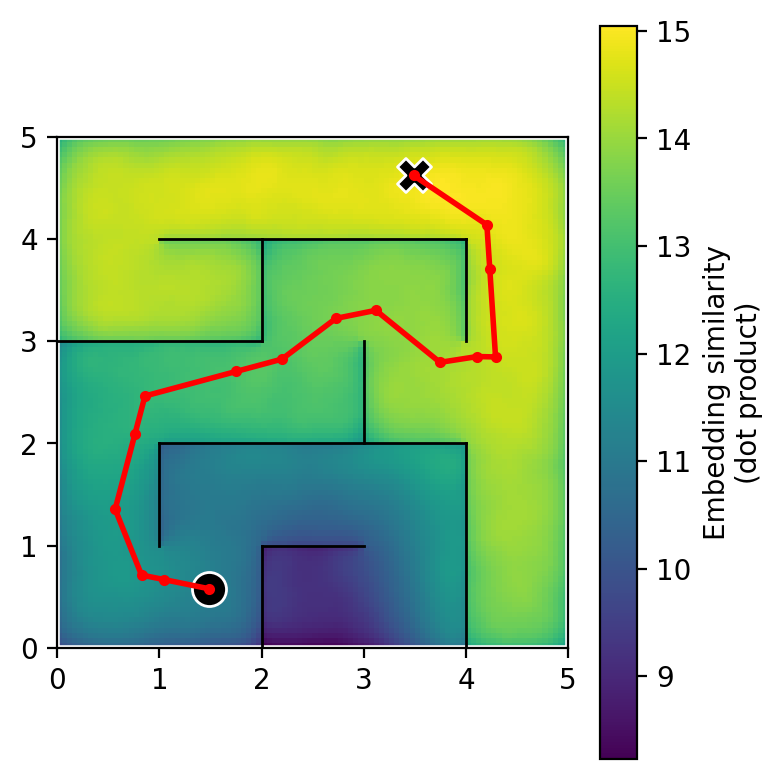

In [26]:
# =========================
# FULL UPDATED BLOCK:
# - sample N_nodes with clearance from walls+boundaries
# - nearest node snapping uses clearance-aware visibility
# - adjacency uses clearance-aware visibility (inflated walls)
# - sim_map computed EXACTLY your way (query_pc -> query_emb -> emb_grid dot)
# - plot uses your imshow + overlays walls + nodes + executed path
#
# Assumes these ALREADY exist in your notebook:
#   place_activation_positions, place_centers, length_scale, W_pc_to_mem
#   emb_grid (grid_res*grid_res, N_mem), grid_res (int)
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# 0) Maze
# -------------------------
env_size = 5.0
walls_np = np.array([
    [1, 4, 4, 4],
    [4, 4, 4, 3],
    [2, 4, 2, 3],
    [0, 3, 2, 3],
    [1, 1, 1, 2],
    [1, 2, 4, 2],
    [4, 2, 4, 0],
    [3, 2, 3, 3],
    [2, 0, 2, 1],
    [2, 1, 3, 1],
], dtype=np.float32)

walls = torch.tensor(walls_np, device=device)
walls_cpu = walls.detach().cpu().numpy()

is_vertical   = torch.isclose(walls[:, 0], walls[:, 2])
is_horizontal = torch.isclose(walls[:, 1], walls[:, 3])
vert_walls = walls[is_vertical]
horiz_walls = walls[is_horizontal]

# -------------------------
# 1) Clearance knob
# -------------------------
CLEAR = 0.15  # keep this distance to boundaries AND walls (planning + nodes + execution)

# -------------------------
# 2) Segment-AABB intersection (CPU) + inflated-wall test (CPU)
# -------------------------
def segment_intersects_aabb_numpy(p0, p1, xmin, xmax, ymin, ymax, eps=1e-12):
    x0, y0 = float(p0[0]), float(p0[1])
    x1, y1 = float(p1[0]), float(p1[1])
    dx, dy = x1 - x0, y1 - y0
    t0, t1 = 0.0, 1.0

    def clip(p, q, t0, t1):
        if abs(p) < eps:
            if q < 0:
                return False, t0, t1
            return True, t0, t1
        r = q / p
        if p < 0:
            if r > t1: return False, t0, t1
            if r > t0: t0 = r
        else:
            if r < t0: return False, t0, t1
            if r < t1: t1 = r
        return True, t0, t1

    ok, t0, t1 = clip(-dx, x0 - xmin, t0, t1)
    if not ok: return False
    ok, t0, t1 = clip(dx, xmax - x0, t0, t1)
    if not ok: return False
    ok, t0, t1 = clip(-dy, y0 - ymin, t0, t1)
    if not ok: return False
    ok, t0, t1 = clip(dy, ymax - y0, t0, t1)
    if not ok: return False

    return t0 <= t1

def segment_hits_inflated_walls_numpy(p0, p1, walls_cpu, clearance, eps=1e-12):
    """
    True if segment p0->p1 intersects the clearance-tube around any wall,
    approximated as an inflated AABB around the axis-aligned segment.
    """
    for (x0, y0, x1, y1) in walls_cpu:
        xmin, xmax = min(x0, x1) - clearance, max(x0, x1) + clearance
        ymin, ymax = min(y0, y1) - clearance, max(y0, y1) + clearance
        if segment_intersects_aabb_numpy(p0, p1, xmin, xmax, ymin, ymax, eps=eps):
            return True
    return False

# -------------------------
# 3) Inflated-wall test for ALL node pairs (GPU)
# -------------------------
@torch.no_grad()
def segment_hits_inflated_walls_torch(A, B, vert_walls, horiz_walls, clearance, eps=1e-9):
    Ax, Ay = A[:, 0], A[:, 1]
    Bx, By = B[:, 0], B[:, 1]
    dx = Bx - Ax
    dy = By - Ay

    blocked = torch.zeros(A.shape[0], dtype=torch.bool, device=A.device)

    def liang_barsky_rect(xmin, xmax, ymin, ymax):
        t0 = torch.zeros_like(Ax)
        t1 = torch.ones_like(Ax)

        def clip(p, q, t0, t1):
            parallel = torch.abs(p) < eps
            reject_parallel = parallel & (q < 0)
            r = q / torch.where(parallel, torch.ones_like(p), p)

            p_neg = (~parallel) & (p < 0)
            p_pos = (~parallel) & (p > 0)

            t0_new = t0.clone()
            t1_new = t1.clone()

            t0_new[p_neg] = torch.maximum(t0[p_neg], r[p_neg])
            t1_new[p_pos] = torch.minimum(t1[p_pos], r[p_pos])

            reject = reject_parallel.clone()
            reject |= (p_neg & (r > t1))
            reject |= (p_pos & (r < t0))

            return (~reject), t0_new, t1_new

        ok, t0, t1 = clip(-dx, Ax - xmin, t0, t1)
        ok2, t0, t1 = clip(dx, xmax - Ax, t0, t1); ok = ok & ok2
        ok2, t0, t1 = clip(-dy, Ay - ymin, t0, t1); ok = ok & ok2
        ok2, t0, t1 = clip(dy, ymax - Ay, t0, t1); ok = ok & ok2
        return ok & (t0 <= t1)

    # vertical wall rectangles
    if vert_walls.numel() > 0:
        xw = vert_walls[:, 0]
        y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
        y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])
        for k in range(xw.numel()):
            blocked |= liang_barsky_rect(
                xw[k] - clearance, xw[k] + clearance,
                y0[k] - clearance, y1[k] + clearance
            )

    # horizontal wall rectangles
    if horiz_walls.numel() > 0:
        yw = horiz_walls[:, 1]
        x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
        x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])
        for k in range(yw.numel()):
            blocked |= liang_barsky_rect(
                x0[k] - clearance, x1[k] + clearance,
                yw[k] - clearance, yw[k] + clearance
            )

    return blocked

# -------------------------
# 4) Sample nodes only in free space (clearance from boundary + walls)
# -------------------------
@torch.no_grad()
def sample_nodes_safe(N, env_size, vert_walls, horiz_walls, clearance, device, batch=4096, max_iters=200):
    out = []
    need = N
    for _ in range(max_iters):
        m = max(batch, need * 4)
        pts = torch.rand(m, 2, device=device) * (env_size - 2*clearance) + clearance  # boundary-safe

        bad = torch.zeros(m, dtype=torch.bool, device=device)

        if vert_walls.numel() > 0:
            xw = vert_walls[:, 0]
            y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
            y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])
            px = pts[:, 0].unsqueeze(1)
            py = pts[:, 1].unsqueeze(1)
            near_x = torch.abs(px - xw.view(1, -1)) < clearance
            near_y = (py >= (y0.view(1, -1) - clearance)) & (py <= (y1.view(1, -1) + clearance))
            bad |= (near_x & near_y).any(dim=1)

        if horiz_walls.numel() > 0:
            yw = horiz_walls[:, 1]
            x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
            x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])
            px = pts[:, 0].unsqueeze(1)
            py = pts[:, 1].unsqueeze(1)
            near_y = torch.abs(py - yw.view(1, -1)) < clearance
            near_x = (px >= (x0.view(1, -1) - clearance)) & (px <= (x1.view(1, -1) + clearance))
            bad |= (near_y & near_x).any(dim=1)

        good = pts[~bad]
        if good.numel() == 0:
            continue

        take = min(need, good.shape[0])
        out.append(good[:take])
        need -= take
        if need <= 0:
            break

    if need > 0:
        raise RuntimeError(f"Could not sample enough safe nodes (need {need} more). Reduce CLEAR or increase max_iters/batch.")
    return torch.cat(out, dim=0)

# -------------------------
# 5) Nearest visible (clearance-aware) node
# -------------------------
def nearest_visible_node_idx(pos, nodes, walls_cpu, clearance, env_size=5.0):
    pos_cpu = pos.detach().cpu().numpy()
    nodes_cpu = nodes.detach().cpu().numpy()

    best_i, best_d2 = None, float("inf")
    for i in range(nodes_cpu.shape[0]):
        p1 = nodes_cpu[i]

        # boundary-safe endpoint
        if (p1[0] < clearance) or (p1[0] > env_size - clearance) or (p1[1] < clearance) or (p1[1] > env_size - clearance):
            continue

        # endpoint not inside any inflated wall rectangle
        inside = False
        for (wx0, wy0, wx1, wy1) in walls_cpu:
            xmin, xmax = min(wx0, wx1) - clearance, max(wx0, wx1) + clearance
            ymin, ymax = min(wy0, wy1) - clearance, max(wy0, wy1) + clearance
            if (xmin <= p1[0] <= xmax) and (ymin <= p1[1] <= ymax):
                inside = True
                break
        if inside:
            continue

        # segment must avoid inflated walls too
        if not segment_hits_inflated_walls_numpy(pos_cpu, p1, walls_cpu, clearance):
            dx = p1[0] - pos_cpu[0]
            dy = p1[1] - pos_cpu[1]
            d2 = dx*dx + dy*dy
            if d2 < best_d2:
                best_d2, best_i = d2, i

    if best_i is not None:
        return int(best_i)

    d2 = ((nodes - pos.unsqueeze(0)) ** 2).sum(dim=1)
    return int(torch.argmin(d2).item())

# -------------------------
# 6) Build clearance-safe adjacency (edges avoid inflated walls)
# -------------------------
@torch.no_grad()
def build_clearance_adj(nodes, vert_walls, horiz_walls, clearance):
    N = nodes.shape[0]
    A = nodes.unsqueeze(1).expand(N, N, 2).reshape(-1, 2)
    B = nodes.unsqueeze(0).expand(N, N, 2).reshape(-1, 2)

    blocked = segment_hits_inflated_walls_torch(A, B, vert_walls, horiz_walls, clearance)

    idx = torch.arange(N, device=nodes.device)
    diag = (idx.unsqueeze(1) == idx.unsqueeze(0)).reshape(-1)
    blocked |= diag
    return (~blocked).reshape(N, N)

# -------------------------
# 7) Greedy planner (EMBEDDING-BASED, uses your emb_nodes + goal_emb)
# -------------------------
def greedy_plan_from_node(start_idx, goal_idx, adj, emb_nodes, goal_emb, max_steps=100):
    path_idx = [start_idx]
    for _ in range(max_steps):
        cur = path_idx[-1]
        if cur == goal_idx:
            break
        if adj[cur, goal_idx]:
            path_idx.append(goal_idx)
            break

        neigh = torch.nonzero(adj[cur], as_tuple=False).squeeze(1)
        if neigh.numel() == 0:
            break

        utils = (emb_nodes[neigh] @ goal_emb.t()).squeeze(1)
        nxt = int(neigh[torch.argmax(utils)].item())
        if nxt in path_idx:
            break
        path_idx.append(nxt)
    return path_idx

# -------------------------
# 8) Execution helpers (clearance-safe)
# -------------------------
def can_go_straight(pos, target, walls_cpu, clearance, env_size=5.0):
    p0 = pos.detach().cpu().numpy()
    p1 = target.detach().cpu().numpy()
    if (p1[0] < clearance) or (p1[0] > env_size - clearance) or (p1[1] < clearance) or (p1[1] > env_size - clearance):
        return False
    return (not segment_hits_inflated_walls_numpy(p0, p1, walls_cpu, clearance))

def safe_fractional_move(pos, target, walls_cpu, clearance, frac=0.5, min_frac=1e-3, iters=20):
    cand = pos + frac * (target - pos)
    if can_go_straight(pos, cand, walls_cpu, clearance, env_size=env_size):
        return cand, float(frac)

    lo, hi = 0.0, float(frac)
    best = 0.0
    for _ in range(iters):
        mid = 0.5 * (lo + hi)
        cand = pos + mid * (target - pos)
        if can_go_straight(pos, cand, walls_cpu, clearance, env_size=env_size):
            best = mid
            lo = mid
        else:
            hi = mid

    if best < min_frac:
        return pos, 0.0
    return pos + best * (target - pos), best

# ============================================================
# 9) MAIN: sample nodes (safe), snap start/goal, compute sim_map YOUR WAY
# ============================================================
N_nodes = 500
nodes = sample_nodes_safe(N_nodes, env_size, vert_walls, horiz_walls, CLEAR, device=device)

start_pos = torch.tensor([1.5, 0.5], device=device)
goal_pos  = torch.tensor([3.5, 4.5], device=device)

start_idx = nearest_visible_node_idx(start_pos, nodes, walls_cpu, CLEAR, env_size=env_size)
goal_idx  = nearest_visible_node_idx(goal_pos,  nodes, walls_cpu, CLEAR, env_size=env_size)

goal_point = nodes[goal_idx:goal_idx+1]  # (1,2)
query_point = goal_point
print("goal point:", goal_point, "index:", goal_idx)

# ---- YOUR sim_map computation (unchanged) ----
query_pc = place_activation_positions(
    query_point,
    place_centers,
    length_scale,
    walls,          # <--- keep wall masking inside PC response
    batch_size=256,
)   # (1, P)

query_emb = query_pc @ W_pc_to_mem   # (1, N_mem)
similarity = (emb_grid @ query_emb.t()).squeeze(1)  # (grid_res*grid_res,)
sim_map = similarity.reshape(grid_res, grid_res)

# ============================================================
# 10) Build adjacency and node embeddings (embedding planner)
# ============================================================
adj = build_clearance_adj(nodes, vert_walls, horiz_walls, CLEAR)

pc_nodes = place_activation_positions(
    nodes,
    place_centers,
    length_scale,
    walls,
    batch_size=256,
)  # (N_nodes, P)
emb_nodes = pc_nodes @ W_pc_to_mem   # (N_nodes, N_mem)

goal_emb = emb_nodes[goal_idx:goal_idx+1]  # (1, N_mem)

# ============================================================
# 11) Receding-horizon execution (clearance-safe)
# ============================================================
max_rounds = 30
plan_horizon = 100
goal_tol = 0.03

pos = nodes[start_idx].clone()
goal_node = nodes[goal_idx].clone()
loc_path = [pos.clone()]

for _ in range(max_rounds):
    if torch.norm(pos - goal_node) < goal_tol:
        break

    # direct to goal if clearance-safe
    if can_go_straight(pos, goal_node, walls_cpu, CLEAR, env_size=env_size):
        pos = goal_node.clone()
        loc_path.append(pos.clone())
        break

    cur_idx = nearest_visible_node_idx(pos, nodes, walls_cpu, CLEAR, env_size=env_size)

    plan_idx = greedy_plan_from_node(
        start_idx=cur_idx,
        goal_idx=goal_idx,
        adj=adj,
        emb_nodes=emb_nodes,
        goal_emb=goal_emb,
        max_steps=plan_horizon,
    )
    if len(plan_idx) < 2:
        break

    nxt = plan_idx[1]
    target = nodes[nxt]

    # move halfway but enforce clearance-safe segment
    new_pos, used = safe_fractional_move(pos, target, walls_cpu, CLEAR, frac=0.5)
    if used == 0.0:
        pos = nodes[cur_idx].clone()
    else:
        pos = new_pos

    loc_path.append(pos.clone())

loc_path = torch.stack(loc_path, dim=0)

# ============================================================
# 12) Plot: YOUR imshow + maze + nodes + executed path
# ============================================================
sim_map_cpu = sim_map.detach().cpu().numpy()
nodes_cpu = nodes.detach().cpu().numpy()
loc_cpu = loc_path.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(4,4),dpi=200)

# ---- your imshow exactly ----
im = ax.imshow(
    np.log(sim_map_cpu),
    origin='lower',
    extent=[0, env_size, 0, env_size],
    cmap='viridis'
)
plt.colorbar(im, ax=ax, label="Embedding similarity\n(dot product)")

# boundary + walls (white)
ax.plot([0, env_size, env_size, 0, 0],
        [0, 0, env_size, env_size, 0],
        'w-', linewidth=2)

for (x0, y0, x1, y1) in walls_cpu:
    ax.plot([x0, x1], [y0, y1], 'w-', linewidth=1,c='black')

# nodes
# ax.scatter(nodes_cpu[:, 0], nodes_cpu[:, 1], s=10, alpha=0.25, c='white')

# executed path
ax.plot(loc_cpu[:, 0], loc_cpu[:, 1], '-o', color='red', linewidth=2, markersize=3)

# start & goal nodes
ax.scatter(nodes_cpu[start_idx, 0], nodes_cpu[start_idx, 1],
           s=150, c='black', edgecolors='white', linewidths=1.0, label='start')
ax.scatter(nodes_cpu[goal_idx, 0], nodes_cpu[goal_idx, 1],
           s=150, c='black', edgecolors='white', linewidths=1.0, marker='X', label='goal')

ax.set_xlim(0, env_size)
ax.set_ylim(0, env_size)
ax.set_aspect('equal', 'box')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_3624248/4040999057.py:215: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'w-', linewidth=3, c='black')


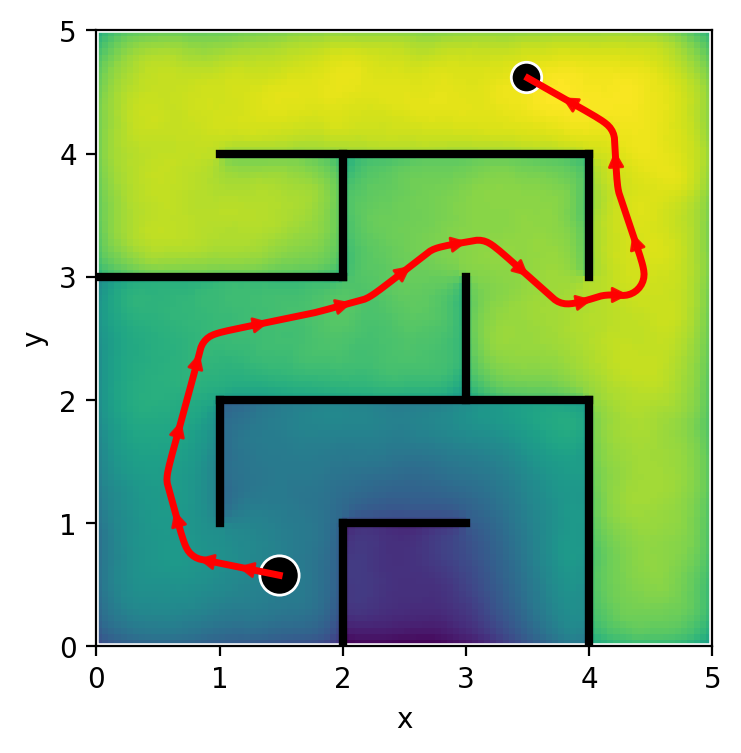

In [32]:
import numpy as np
from matplotlib.patches import FancyArrowPatch

def _segment_crosses_walls(p0, p1, walls_cpu, eps=1e-12):
    """
    p0, p1: (2,) numpy
    walls_cpu: (n_walls, 4) numpy [x0,y0,x1,y1], axis-aligned
    Returns True if segment p0->p1 intersects any wall (proper crossing).
    """
    x0, y0 = float(p0[0]), float(p0[1])
    x1, y1 = float(p1[0]), float(p1[1])

    # quick reject degenerate
    if abs(x0 - x1) < eps and abs(y0 - y1) < eps:
        return False

    for (wx0, wy0, wx1, wy1) in walls_cpu:
        wx0, wy0, wx1, wy1 = float(wx0), float(wy0), float(wx1), float(wy1)

        # vertical wall: x = const
        if abs(wx0 - wx1) < eps:
            xw = wx0
            ylo = min(wy0, wy1)
            yhi = max(wy0, wy1)

            # must cross xw strictly (different sides)
            if (x0 - xw) * (x1 - xw) < 0:
                # compute y at intersection x=xw
                denom = (x1 - x0)
                if abs(denom) < eps:
                    continue
                t = (xw - x0) / denom
                if 0.0 <= t <= 1.0:
                    y_int = y0 + t * (y1 - y0)
                    if (ylo - eps) <= y_int <= (yhi + eps):
                        return True

        # horizontal wall: y = const
        elif abs(wy0 - wy1) < eps:
            yw = wy0
            xlo = min(wx0, wx1)
            xhi = max(wx0, wx1)

            if (y0 - yw) * (y1 - yw) < 0:
                denom = (y1 - y0)
                if abs(denom) < eps:
                    continue
                t = (yw - y0) / denom
                if 0.0 <= t <= 1.0:
                    x_int = x0 + t * (x1 - x0)
                    if (xlo - eps) <= x_int <= (xhi + eps):
                        return True

    return False


def _wrap_pi(a):
    """wrap angle to (-pi, pi]"""
    return (a + np.pi) % (2*np.pi) - np.pi


def smooth_path_continuous_turning(
    waypoints,          # (K,2) numpy
    walls_cpu,          # (n_walls,4) numpy
    env_size,
    step=0.02,          # spatial step per integration tick
    kappa=0.35,         # turning gain (0..1-ish); higher = turns faster
    max_turn=np.deg2rad(8.0),   # max heading change per tick (smoothness control)
    goal_tol=0.03,
    max_iters=200000,
    avoid_delta=np.deg2rad(4.0),  # angular increment when avoiding collision
    avoid_tries=60,
):
    """
    Returns:
      path_xy: (T,2) numpy continuous trajectory
      arrows: list of (pos, dir_hat) for midpoint arrows per waypoint leg
    """
    wp = np.asarray(waypoints, float)
    assert wp.ndim == 2 and wp.shape[1] == 2

    pos = wp[0].copy()
    path = [pos.copy()]
    arrows = []

    # initial heading points toward first target (if exists)
    leg = 1
    if len(wp) > 1:
        v0 = wp[1] - wp[0]
        theta = np.arctan2(v0[1], v0[0]) if np.linalg.norm(v0) > 1e-12 else 0.0
    else:
        theta = 0.0

    # For arrows: record midpoints per leg
    leg_start_idx = 0

    it = 0
    while leg < len(wp) and it < max_iters:
        it += 1
        target = wp[leg]
        to = target - pos
        dist = np.linalg.norm(to)

        # reached current waypoint -> advance leg
        if dist < goal_tol:
            # arrow at midpoint of leg (if leg had some length)
            leg_end_idx = len(path) - 1
            if leg_end_idx > leg_start_idx + 2:
                mid_idx = (leg_start_idx + leg_end_idx) // 2
                p_mid = np.array(path[mid_idx])
                # tangent at midpoint from neighbors
                p0 = np.array(path[max(mid_idx-1, 0)])
                p1 = np.array(path[min(mid_idx+1, len(path)-1)])
                d = p1 - p0
                n = np.linalg.norm(d)
                if n > 1e-9:
                    arrows.append((p_mid, d / n))
            leg_start_idx = len(path) - 1

            leg += 1
            continue

        desired = np.arctan2(to[1], to[0])
        dtheta = _wrap_pi(desired - theta)

        # continuous angular adjustment (bounded)
        theta = theta + np.clip(kappa * dtheta, -max_turn, +max_turn)

        # propose forward step
        new_pos = pos + step * np.array([np.cos(theta), np.sin(theta)], float)

        # boundary clamp check (treat as collision to preserve smooth steering)
        if not (0.0 <= new_pos[0] <= env_size and 0.0 <= new_pos[1] <= env_size):
            collided = True
        else:
            collided = _segment_crosses_walls(pos, new_pos, walls_cpu)

        if collided:
            # try nearby headings around current theta to find collision-free step
            found = False
            base = theta
            for k in range(1, avoid_tries + 1):
                for sgn in (+1, -1):
                    th_try = base + sgn * k * avoid_delta
                    cand = pos + step * np.array([np.cos(th_try), np.sin(th_try)], float)

                    if not (0.0 <= cand[0] <= env_size and 0.0 <= cand[1] <= env_size):
                        continue
                    if _segment_crosses_walls(pos, cand, walls_cpu):
                        continue

                    theta = th_try
                    new_pos = cand
                    found = True
                    break
                if found:
                    break

            if not found:
                # last resort: reduce step a bit and try again next iteration
                step = max(step * 0.7, 1e-4)
                continue

        pos = new_pos
        path.append(pos.copy())

    return np.asarray(path, float), arrows


def draw_mid_arrows(ax, arrows, length=0.15, color="white", mutation_scale=12, alpha=0.9, zorder=6):
    for p, d_hat in arrows:
        p0 = p
        p1 = p0 + length * d_hat
        ax.add_patch(FancyArrowPatch(
            posA=(p0[0], p0[1]), posB=(p1[0], p1[1]),
            arrowstyle='-|>', mutation_scale=mutation_scale,
            color=color, lw=1.0, alpha=alpha, zorder=zorder
        ))


# --- build continuous smooth path from your discrete node plan ---
walls_cpu = walls.detach().cpu().numpy()

waypoints = loc_cpu
smooth_path, arrows = smooth_path_continuous_turning(
    loc_cpu,
    walls_cpu=walls_cpu,
    env_size=env_size,
    step=0.03,                 # <-- try 0.02~0.05
    kappa=0.45,                # <-- larger = turns faster
    max_turn=np.deg2rad(10.0), # <-- smaller = smoother (but wider turns)
    goal_tol=0.04,
)
fig, ax = plt.subplots(figsize=(4, 4),dpi=200)

im = ax.imshow(
    np.log(sim_map_cpu),
    origin='lower',
    extent=[0, env_size, 0, env_size],
    alpha=1
#     cmap='YlOrBr'
)
# plt.colorbar(im, ax=ax, label="Embedding similarity\n(dot product)")

# draw maze boundaries and walls in white for contrast
ax.plot(
    [0, env_size, env_size, 0, 0],
    [0, 0, env_size, env_size, 0],
    'w-',
    linewidth=2
)

walls_cpu = walls.detach().cpu().numpy()
for (x0, y0, x1, y1) in walls_cpu:
    ax.plot([x0, x1], [y0, y1], 'w-', linewidth=3, c='black')

# mark query point
# ax.scatter(0.5, 0.5, color='cyan', s=60, edgecolors='black', label="query (2.5, 2.5)")

ax.set_xlim(0, env_size)
ax.set_ylim(0, env_size)
ax.set_aspect('equal', 'box')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(
    nodes_cpu[start_idx, 0],
    nodes_cpu[start_idx, 1],
    s=200,
    c='black',
    edgecolors='white',
    label='start',
)

ax.scatter(
    nodes_cpu[goal_idx, 0],
    nodes_cpu[goal_idx, 1],
    s=120,
    c='black',
    edgecolors='white',
    label='goal',
)
# plot the smooth path instead of the polyline
ax.plot(smooth_path[:, 0], smooth_path[:, 1], '-', color='red', lw=2.5, label='smooth (continuous turn)')
draw_mid_arrows(ax, arrows, length=0.18, color="red", mutation_scale=12)

goal point: tensor([[1.4558, 1.4546]], device='cuda:0') index: 138


/tmp/ipykernel_3624248/565668758.py:436: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'w-', linewidth=1,c='black')


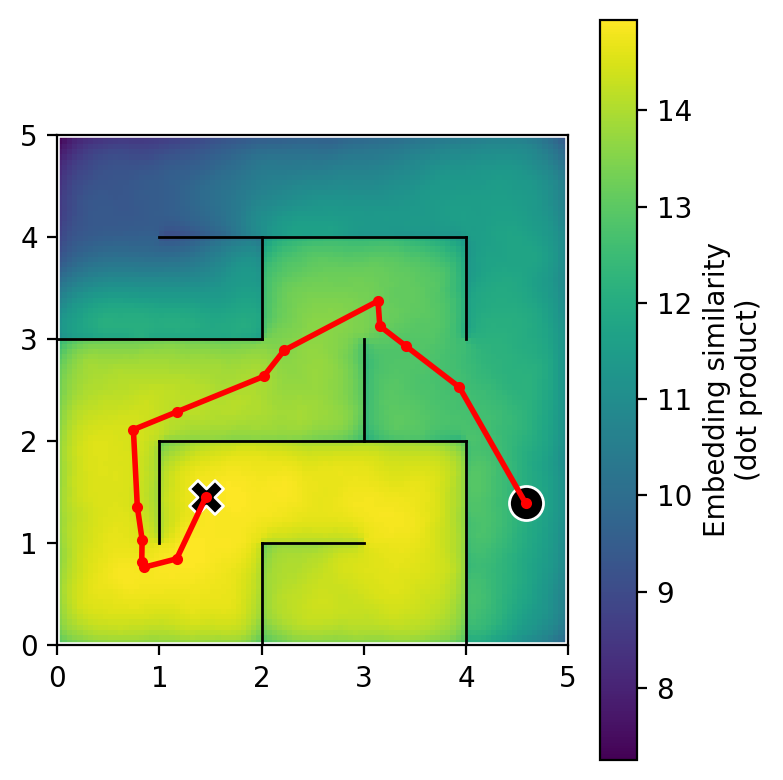

In [44]:
# =========================
# FULL UPDATED BLOCK:
# - sample N_nodes with clearance from walls+boundaries
# - nearest node snapping uses clearance-aware visibility
# - adjacency uses clearance-aware visibility (inflated walls)
# - sim_map computed EXACTLY your way (query_pc -> query_emb -> emb_grid dot)
# - plot uses your imshow + overlays walls + nodes + executed path
#
# Assumes these ALREADY exist in your notebook:
#   place_activation_positions, place_centers, length_scale, W_pc_to_mem
#   emb_grid (grid_res*grid_res, N_mem), grid_res (int)
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# 0) Maze
# -------------------------
env_size = 5.0
walls_np = np.array([
    [1, 4, 4, 4],
    [4, 4, 4, 3],
    [2, 4, 2, 3],
    [0, 3, 2, 3],
    [1, 1, 1, 2],
    [1, 2, 4, 2],
    [4, 2, 4, 0],
    [3, 2, 3, 3],
    [2, 0, 2, 1],
    [2, 1, 3, 1],
], dtype=np.float32)

walls = torch.tensor(walls_np, device=device)
walls_cpu = walls.detach().cpu().numpy()

is_vertical   = torch.isclose(walls[:, 0], walls[:, 2])
is_horizontal = torch.isclose(walls[:, 1], walls[:, 3])
vert_walls = walls[is_vertical]
horiz_walls = walls[is_horizontal]

# -------------------------
# 1) Clearance knob
# -------------------------
CLEAR = 0.15  # keep this distance to boundaries AND walls (planning + nodes + execution)

# -------------------------
# 2) Segment-AABB intersection (CPU) + inflated-wall test (CPU)
# -------------------------
def segment_intersects_aabb_numpy(p0, p1, xmin, xmax, ymin, ymax, eps=1e-12):
    x0, y0 = float(p0[0]), float(p0[1])
    x1, y1 = float(p1[0]), float(p1[1])
    dx, dy = x1 - x0, y1 - y0
    t0, t1 = 0.0, 1.0

    def clip(p, q, t0, t1):
        if abs(p) < eps:
            if q < 0:
                return False, t0, t1
            return True, t0, t1
        r = q / p
        if p < 0:
            if r > t1: return False, t0, t1
            if r > t0: t0 = r
        else:
            if r < t0: return False, t0, t1
            if r < t1: t1 = r
        return True, t0, t1

    ok, t0, t1 = clip(-dx, x0 - xmin, t0, t1)
    if not ok: return False
    ok, t0, t1 = clip(dx, xmax - x0, t0, t1)
    if not ok: return False
    ok, t0, t1 = clip(-dy, y0 - ymin, t0, t1)
    if not ok: return False
    ok, t0, t1 = clip(dy, ymax - y0, t0, t1)
    if not ok: return False

    return t0 <= t1

def segment_hits_inflated_walls_numpy(p0, p1, walls_cpu, clearance, eps=1e-12):
    """
    True if segment p0->p1 intersects the clearance-tube around any wall,
    approximated as an inflated AABB around the axis-aligned segment.
    """
    for (x0, y0, x1, y1) in walls_cpu:
        xmin, xmax = min(x0, x1) - clearance, max(x0, x1) + clearance
        ymin, ymax = min(y0, y1) - clearance, max(y0, y1) + clearance
        if segment_intersects_aabb_numpy(p0, p1, xmin, xmax, ymin, ymax, eps=eps):
            return True
    return False

# -------------------------
# 3) Inflated-wall test for ALL node pairs (GPU)
# -------------------------
@torch.no_grad()
def segment_hits_inflated_walls_torch(A, B, vert_walls, horiz_walls, clearance, eps=1e-9):
    Ax, Ay = A[:, 0], A[:, 1]
    Bx, By = B[:, 0], B[:, 1]
    dx = Bx - Ax
    dy = By - Ay

    blocked = torch.zeros(A.shape[0], dtype=torch.bool, device=A.device)

    def liang_barsky_rect(xmin, xmax, ymin, ymax):
        t0 = torch.zeros_like(Ax)
        t1 = torch.ones_like(Ax)

        def clip(p, q, t0, t1):
            parallel = torch.abs(p) < eps
            reject_parallel = parallel & (q < 0)
            r = q / torch.where(parallel, torch.ones_like(p), p)

            p_neg = (~parallel) & (p < 0)
            p_pos = (~parallel) & (p > 0)

            t0_new = t0.clone()
            t1_new = t1.clone()

            t0_new[p_neg] = torch.maximum(t0[p_neg], r[p_neg])
            t1_new[p_pos] = torch.minimum(t1[p_pos], r[p_pos])

            reject = reject_parallel.clone()
            reject |= (p_neg & (r > t1))
            reject |= (p_pos & (r < t0))

            return (~reject), t0_new, t1_new

        ok, t0, t1 = clip(-dx, Ax - xmin, t0, t1)
        ok2, t0, t1 = clip(dx, xmax - Ax, t0, t1); ok = ok & ok2
        ok2, t0, t1 = clip(-dy, Ay - ymin, t0, t1); ok = ok & ok2
        ok2, t0, t1 = clip(dy, ymax - Ay, t0, t1); ok = ok & ok2
        return ok & (t0 <= t1)

    # vertical wall rectangles
    if vert_walls.numel() > 0:
        xw = vert_walls[:, 0]
        y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
        y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])
        for k in range(xw.numel()):
            blocked |= liang_barsky_rect(
                xw[k] - clearance, xw[k] + clearance,
                y0[k] - clearance, y1[k] + clearance
            )

    # horizontal wall rectangles
    if horiz_walls.numel() > 0:
        yw = horiz_walls[:, 1]
        x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
        x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])
        for k in range(yw.numel()):
            blocked |= liang_barsky_rect(
                x0[k] - clearance, x1[k] + clearance,
                yw[k] - clearance, yw[k] + clearance
            )

    return blocked

# -------------------------
# 4) Sample nodes only in free space (clearance from boundary + walls)
# -------------------------
@torch.no_grad()
def sample_nodes_safe(N, env_size, vert_walls, horiz_walls, clearance, device, batch=4096, max_iters=200):
    out = []
    need = N
    for _ in range(max_iters):
        m = max(batch, need * 4)
        pts = torch.rand(m, 2, device=device) * (env_size - 2*clearance) + clearance  # boundary-safe

        bad = torch.zeros(m, dtype=torch.bool, device=device)

        if vert_walls.numel() > 0:
            xw = vert_walls[:, 0]
            y0 = torch.minimum(vert_walls[:, 1], vert_walls[:, 3])
            y1 = torch.maximum(vert_walls[:, 1], vert_walls[:, 3])
            px = pts[:, 0].unsqueeze(1)
            py = pts[:, 1].unsqueeze(1)
            near_x = torch.abs(px - xw.view(1, -1)) < clearance
            near_y = (py >= (y0.view(1, -1) - clearance)) & (py <= (y1.view(1, -1) + clearance))
            bad |= (near_x & near_y).any(dim=1)

        if horiz_walls.numel() > 0:
            yw = horiz_walls[:, 1]
            x0 = torch.minimum(horiz_walls[:, 0], horiz_walls[:, 2])
            x1 = torch.maximum(horiz_walls[:, 0], horiz_walls[:, 2])
            px = pts[:, 0].unsqueeze(1)
            py = pts[:, 1].unsqueeze(1)
            near_y = torch.abs(py - yw.view(1, -1)) < clearance
            near_x = (px >= (x0.view(1, -1) - clearance)) & (px <= (x1.view(1, -1) + clearance))
            bad |= (near_y & near_x).any(dim=1)

        good = pts[~bad]
        if good.numel() == 0:
            continue

        take = min(need, good.shape[0])
        out.append(good[:take])
        need -= take
        if need <= 0:
            break

    if need > 0:
        raise RuntimeError(f"Could not sample enough safe nodes (need {need} more). Reduce CLEAR or increase max_iters/batch.")
    return torch.cat(out, dim=0)

# -------------------------
# 5) Nearest visible (clearance-aware) node
# -------------------------
def nearest_visible_node_idx(pos, nodes, walls_cpu, clearance, env_size=5.0):
    pos_cpu = pos.detach().cpu().numpy()
    nodes_cpu = nodes.detach().cpu().numpy()

    best_i, best_d2 = None, float("inf")
    for i in range(nodes_cpu.shape[0]):
        p1 = nodes_cpu[i]

        # boundary-safe endpoint
        if (p1[0] < clearance) or (p1[0] > env_size - clearance) or (p1[1] < clearance) or (p1[1] > env_size - clearance):
            continue

        # endpoint not inside any inflated wall rectangle
        inside = False
        for (wx0, wy0, wx1, wy1) in walls_cpu:
            xmin, xmax = min(wx0, wx1) - clearance, max(wx0, wx1) + clearance
            ymin, ymax = min(wy0, wy1) - clearance, max(wy0, wy1) + clearance
            if (xmin <= p1[0] <= xmax) and (ymin <= p1[1] <= ymax):
                inside = True
                break
        if inside:
            continue

        # segment must avoid inflated walls too
        if not segment_hits_inflated_walls_numpy(pos_cpu, p1, walls_cpu, clearance):
            dx = p1[0] - pos_cpu[0]
            dy = p1[1] - pos_cpu[1]
            d2 = dx*dx + dy*dy
            if d2 < best_d2:
                best_d2, best_i = d2, i

    if best_i is not None:
        return int(best_i)

    d2 = ((nodes - pos.unsqueeze(0)) ** 2).sum(dim=1)
    return int(torch.argmin(d2).item())

# -------------------------
# 6) Build clearance-safe adjacency (edges avoid inflated walls)
# -------------------------
@torch.no_grad()
def build_clearance_adj(nodes, vert_walls, horiz_walls, clearance):
    N = nodes.shape[0]
    A = nodes.unsqueeze(1).expand(N, N, 2).reshape(-1, 2)
    B = nodes.unsqueeze(0).expand(N, N, 2).reshape(-1, 2)

    blocked = segment_hits_inflated_walls_torch(A, B, vert_walls, horiz_walls, clearance)

    idx = torch.arange(N, device=nodes.device)
    diag = (idx.unsqueeze(1) == idx.unsqueeze(0)).reshape(-1)
    blocked |= diag
    return (~blocked).reshape(N, N)

# -------------------------
# 7) Greedy planner (EMBEDDING-BASED, uses your emb_nodes + goal_emb)
# -------------------------
def greedy_plan_from_node(start_idx, goal_idx, adj, emb_nodes, goal_emb, max_steps=100):
    path_idx = [start_idx]
    for _ in range(max_steps):
        cur = path_idx[-1]
        if cur == goal_idx:
            break
        if adj[cur, goal_idx]:
            path_idx.append(goal_idx)
            break

        neigh = torch.nonzero(adj[cur], as_tuple=False).squeeze(1)
        if neigh.numel() == 0:
            break

        utils = (emb_nodes[neigh] @ goal_emb.t()).squeeze(1)
        nxt = int(neigh[torch.argmax(utils)].item())
        if nxt in path_idx:
            break
        path_idx.append(nxt)
    return path_idx

# -------------------------
# 8) Execution helpers (clearance-safe)
# -------------------------
def can_go_straight(pos, target, walls_cpu, clearance, env_size=5.0):
    p0 = pos.detach().cpu().numpy()
    p1 = target.detach().cpu().numpy()
    if (p1[0] < clearance) or (p1[0] > env_size - clearance) or (p1[1] < clearance) or (p1[1] > env_size - clearance):
        return False
    return (not segment_hits_inflated_walls_numpy(p0, p1, walls_cpu, clearance))

def safe_fractional_move(pos, target, walls_cpu, clearance, frac=0.5, min_frac=1e-3, iters=20):
    cand = pos + frac * (target - pos)
    if can_go_straight(pos, cand, walls_cpu, clearance, env_size=env_size):
        return cand, float(frac)

    lo, hi = 0.0, float(frac)
    best = 0.0
    for _ in range(iters):
        mid = 0.5 * (lo + hi)
        cand = pos + mid * (target - pos)
        if can_go_straight(pos, cand, walls_cpu, clearance, env_size=env_size):
            best = mid
            lo = mid
        else:
            hi = mid

    if best < min_frac:
        return pos, 0.0
    return pos + best * (target - pos), best

# ============================================================
# 9) MAIN: sample nodes (safe), snap start/goal, compute sim_map YOUR WAY
# ============================================================
N_nodes = 500
nodes = sample_nodes_safe(N_nodes, env_size, vert_walls, horiz_walls, CLEAR, device=device)

start_pos = torch.tensor([4.5, 1.5], device=device)
goal_pos  = torch.tensor([1.5, 1.5], device=device)

start_idx = nearest_visible_node_idx(start_pos, nodes, walls_cpu, CLEAR, env_size=env_size)
goal_idx  = nearest_visible_node_idx(goal_pos,  nodes, walls_cpu, CLEAR, env_size=env_size)

goal_point = nodes[goal_idx:goal_idx+1]  # (1,2)
query_point = goal_point
print("goal point:", goal_point, "index:", goal_idx)

# ---- YOUR sim_map computation (unchanged) ----
query_pc = place_activation_positions(
    query_point,
    place_centers,
    length_scale,
    walls,          # <--- keep wall masking inside PC response
    batch_size=256,
)   # (1, P)

query_emb = query_pc @ W_pc_to_mem   # (1, N_mem)
similarity = (emb_grid @ query_emb.t()).squeeze(1)  # (grid_res*grid_res,)
sim_map = similarity.reshape(grid_res, grid_res)

# ============================================================
# 10) Build adjacency and node embeddings (embedding planner)
# ============================================================
adj = build_clearance_adj(nodes, vert_walls, horiz_walls, CLEAR)

pc_nodes = place_activation_positions(
    nodes,
    place_centers,
    length_scale,
    walls,
    batch_size=256,
)  # (N_nodes, P)
emb_nodes = pc_nodes @ W_pc_to_mem   # (N_nodes, N_mem)

goal_emb = emb_nodes[goal_idx:goal_idx+1]  # (1, N_mem)

# ============================================================
# 11) Receding-horizon execution (clearance-safe)
# ============================================================
max_rounds = 30
plan_horizon = 100
goal_tol = 0.03

pos = nodes[start_idx].clone()
goal_node = nodes[goal_idx].clone()
loc_path = [pos.clone()]

for _ in range(max_rounds):
    if torch.norm(pos - goal_node) < goal_tol:
        break

    # direct to goal if clearance-safe
    if can_go_straight(pos, goal_node, walls_cpu, CLEAR, env_size=env_size):
        pos = goal_node.clone()
        loc_path.append(pos.clone())
        break

    cur_idx = nearest_visible_node_idx(pos, nodes, walls_cpu, CLEAR, env_size=env_size)

    plan_idx = greedy_plan_from_node(
        start_idx=cur_idx,
        goal_idx=goal_idx,
        adj=adj,
        emb_nodes=emb_nodes,
        goal_emb=goal_emb,
        max_steps=plan_horizon,
    )
    if len(plan_idx) < 2:
        break

    nxt = plan_idx[1]
    target = nodes[nxt]

    # move halfway but enforce clearance-safe segment
    new_pos, used = safe_fractional_move(pos, target, walls_cpu, CLEAR, frac=0.5)
    if used == 0.0:
        pos = nodes[cur_idx].clone()
    else:
        pos = new_pos

    loc_path.append(pos.clone())

loc_path = torch.stack(loc_path, dim=0)

# ============================================================
# 12) Plot: YOUR imshow + maze + nodes + executed path
# ============================================================
sim_map_cpu = sim_map.detach().cpu().numpy()
nodes_cpu = nodes.detach().cpu().numpy()
loc_cpu = loc_path.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(4,4),dpi=200)

# ---- your imshow exactly ----
im = ax.imshow(
    np.log(sim_map_cpu),
    origin='lower',
    extent=[0, env_size, 0, env_size],
    cmap='viridis'
)
plt.colorbar(im, ax=ax, label="Embedding similarity\n(dot product)")

# boundary + walls (white)
ax.plot([0, env_size, env_size, 0, 0],
        [0, 0, env_size, env_size, 0],
        'w-', linewidth=2)

for (x0, y0, x1, y1) in walls_cpu:
    ax.plot([x0, x1], [y0, y1], 'w-', linewidth=1,c='black')

# nodes
# ax.scatter(nodes_cpu[:, 0], nodes_cpu[:, 1], s=10, alpha=0.25, c='white')

# executed path
ax.plot(loc_cpu[:, 0], loc_cpu[:, 1], '-o', color='red', linewidth=2, markersize=3)

# start & goal nodes
ax.scatter(nodes_cpu[start_idx, 0], nodes_cpu[start_idx, 1],
           s=150, c='black', edgecolors='white', linewidths=1.0, label='start')
ax.scatter(nodes_cpu[goal_idx, 0], nodes_cpu[goal_idx, 1],
           s=150, c='black', edgecolors='white', linewidths=1.0, marker='X', label='goal')

ax.set_xlim(0, env_size)
ax.set_ylim(0, env_size)
ax.set_aspect('equal', 'box')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_3624248/3756804965.py:215: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'w-', linewidth=3, c='black')


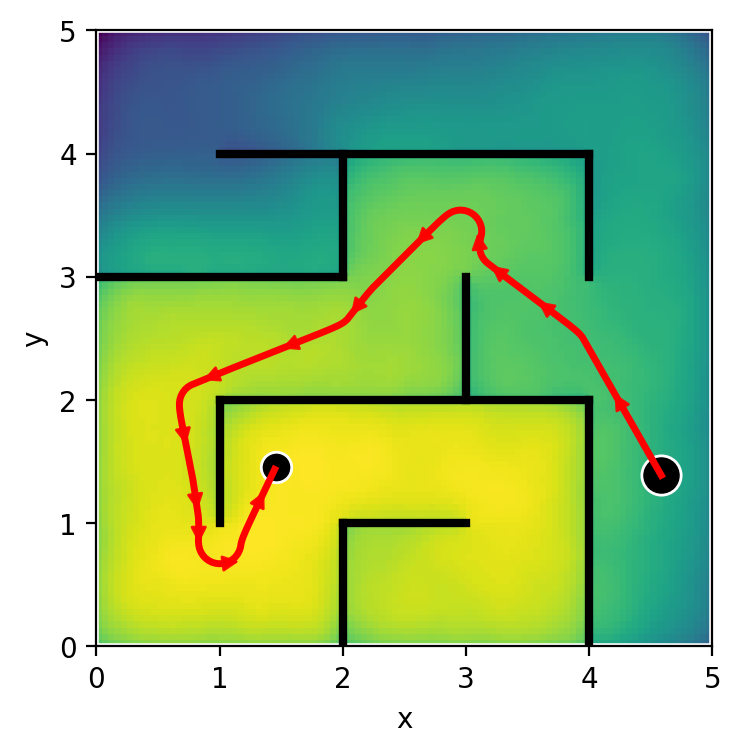

In [46]:
import numpy as np
from matplotlib.patches import FancyArrowPatch

def _segment_crosses_walls(p0, p1, walls_cpu, eps=1e-12):
    """
    p0, p1: (2,) numpy
    walls_cpu: (n_walls, 4) numpy [x0,y0,x1,y1], axis-aligned
    Returns True if segment p0->p1 intersects any wall (proper crossing).
    """
    x0, y0 = float(p0[0]), float(p0[1])
    x1, y1 = float(p1[0]), float(p1[1])

    # quick reject degenerate
    if abs(x0 - x1) < eps and abs(y0 - y1) < eps:
        return False

    for (wx0, wy0, wx1, wy1) in walls_cpu:
        wx0, wy0, wx1, wy1 = float(wx0), float(wy0), float(wx1), float(wy1)

        # vertical wall: x = const
        if abs(wx0 - wx1) < eps:
            xw = wx0
            ylo = min(wy0, wy1)
            yhi = max(wy0, wy1)

            # must cross xw strictly (different sides)
            if (x0 - xw) * (x1 - xw) < 0:
                # compute y at intersection x=xw
                denom = (x1 - x0)
                if abs(denom) < eps:
                    continue
                t = (xw - x0) / denom
                if 0.0 <= t <= 1.0:
                    y_int = y0 + t * (y1 - y0)
                    if (ylo - eps) <= y_int <= (yhi + eps):
                        return True

        # horizontal wall: y = const
        elif abs(wy0 - wy1) < eps:
            yw = wy0
            xlo = min(wx0, wx1)
            xhi = max(wx0, wx1)

            if (y0 - yw) * (y1 - yw) < 0:
                denom = (y1 - y0)
                if abs(denom) < eps:
                    continue
                t = (yw - y0) / denom
                if 0.0 <= t <= 1.0:
                    x_int = x0 + t * (x1 - x0)
                    if (xlo - eps) <= x_int <= (xhi + eps):
                        return True

    return False


def _wrap_pi(a):
    """wrap angle to (-pi, pi]"""
    return (a + np.pi) % (2*np.pi) - np.pi


def smooth_path_continuous_turning(
    waypoints,          # (K,2) numpy
    walls_cpu,          # (n_walls,4) numpy
    env_size,
    step=0.02,          # spatial step per integration tick
    kappa=0.35,         # turning gain (0..1-ish); higher = turns faster
    max_turn=np.deg2rad(8.0),   # max heading change per tick (smoothness control)
    goal_tol=0.03,
    max_iters=200000,
    avoid_delta=np.deg2rad(4.0),  # angular increment when avoiding collision
    avoid_tries=60,
):
    """
    Returns:
      path_xy: (T,2) numpy continuous trajectory
      arrows: list of (pos, dir_hat) for midpoint arrows per waypoint leg
    """
    wp = np.asarray(waypoints, float)
    assert wp.ndim == 2 and wp.shape[1] == 2

    pos = wp[0].copy()
    path = [pos.copy()]
    arrows = []

    # initial heading points toward first target (if exists)
    leg = 1
    if len(wp) > 1:
        v0 = wp[1] - wp[0]
        theta = np.arctan2(v0[1], v0[0]) if np.linalg.norm(v0) > 1e-12 else 0.0
    else:
        theta = 0.0

    # For arrows: record midpoints per leg
    leg_start_idx = 0

    it = 0
    while leg < len(wp) and it < max_iters:
        it += 1
        target = wp[leg]
        to = target - pos
        dist = np.linalg.norm(to)

        # reached current waypoint -> advance leg
        if dist < goal_tol:
            # arrow at midpoint of leg (if leg had some length)
            leg_end_idx = len(path) - 1
            if leg_end_idx > leg_start_idx + 2:
                mid_idx = (leg_start_idx + leg_end_idx) // 2
                p_mid = np.array(path[mid_idx])
                # tangent at midpoint from neighbors
                p0 = np.array(path[max(mid_idx-1, 0)])
                p1 = np.array(path[min(mid_idx+1, len(path)-1)])
                d = p1 - p0
                n = np.linalg.norm(d)
                if n > 1e-9:
                    arrows.append((p_mid, d / n))
            leg_start_idx = len(path) - 1

            leg += 1
            continue

        desired = np.arctan2(to[1], to[0])
        dtheta = _wrap_pi(desired - theta)

        # continuous angular adjustment (bounded)
        theta = theta + np.clip(kappa * dtheta, -max_turn, +max_turn)

        # propose forward step
        new_pos = pos + step * np.array([np.cos(theta), np.sin(theta)], float)

        # boundary clamp check (treat as collision to preserve smooth steering)
        if not (0.0 <= new_pos[0] <= env_size and 0.0 <= new_pos[1] <= env_size):
            collided = True
        else:
            collided = _segment_crosses_walls(pos, new_pos, walls_cpu)

        if collided:
            # try nearby headings around current theta to find collision-free step
            found = False
            base = theta
            for k in range(1, avoid_tries + 1):
                for sgn in (+1, -1):
                    th_try = base + sgn * k * avoid_delta
                    cand = pos + step * np.array([np.cos(th_try), np.sin(th_try)], float)

                    if not (0.0 <= cand[0] <= env_size and 0.0 <= cand[1] <= env_size):
                        continue
                    if _segment_crosses_walls(pos, cand, walls_cpu):
                        continue

                    theta = th_try
                    new_pos = cand
                    found = True
                    break
                if found:
                    break

            if not found:
                # last resort: reduce step a bit and try again next iteration
                step = max(step * 0.7, 1e-4)
                continue

        pos = new_pos
        path.append(pos.copy())

    return np.asarray(path, float), arrows


def draw_mid_arrows(ax, arrows, length=0.15, color="white", mutation_scale=12, alpha=0.9, zorder=6):
    for p, d_hat in arrows:
        p0 = p
        p1 = p0 + length * d_hat
        ax.add_patch(FancyArrowPatch(
            posA=(p0[0], p0[1]), posB=(p1[0], p1[1]),
            arrowstyle='-|>', mutation_scale=mutation_scale,
            color=color, lw=1.0, alpha=alpha, zorder=zorder
        ))


# --- build continuous smooth path from your discrete node plan ---
walls_cpu = walls.detach().cpu().numpy()

waypoints = loc_cpu#nodes[path].detach().cpu().numpy()  # (K,2) from your discrete plan
smooth_path, arrows = smooth_path_continuous_turning(
    loc_cpu,
    walls_cpu=walls_cpu,
    env_size=env_size,
    step=0.03,                 # <-- try 0.02~0.05
    kappa=0.45,                # <-- larger = turns faster
    max_turn=np.deg2rad(10.0), # <-- smaller = smoother (but wider turns)
    goal_tol=0.04,
)
fig, ax = plt.subplots(figsize=(4, 4),dpi=200)

im = ax.imshow(
    np.log(sim_map_cpu),
    origin='lower',
    extent=[0, env_size, 0, env_size],
    alpha=1
#     cmap='YlOrBr'
)
# plt.colorbar(im, ax=ax, label="Embedding similarity\n(dot product)")

# draw maze boundaries and walls in white for contrast
ax.plot(
    [0, env_size, env_size, 0, 0],
    [0, 0, env_size, env_size, 0],
    'w-',
    linewidth=2
)

walls_cpu = walls.detach().cpu().numpy()
for (x0, y0, x1, y1) in walls_cpu:
    ax.plot([x0, x1], [y0, y1], 'w-', linewidth=3, c='black')

# mark query point
# ax.scatter(0.5, 0.5, color='cyan', s=60, edgecolors='black', label="query (2.5, 2.5)")

ax.set_xlim(0, env_size)
ax.set_ylim(0, env_size)
ax.set_aspect('equal', 'box')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(
    nodes_cpu[start_idx, 0],
    nodes_cpu[start_idx, 1],
    s=200,
    c='black',
    edgecolors='white',
    label='start',
)

ax.scatter(
    nodes_cpu[goal_idx, 0],
    nodes_cpu[goal_idx, 1],
    s=120,
    c='black',
    edgecolors='white',
    label='goal',
)
# plot the smooth path instead of the polyline
ax.plot(smooth_path[:, 0], smooth_path[:, 1], '-', color='red', lw=2.5, label='smooth (continuous turn)')
draw_mid_arrows(ax, arrows, length=0.18, color="red", mutation_scale=12)